In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from io import BytesIO

sns.set_theme()

De los datasets solo me quedaré con Penetración, Precio, ConsumoXCapita, GastoXCapita, Socioeconómico ConsumoXCapita, SocioEconómico Penetración


Solo hace falta que vaya por zips

In [3]:
def dataset_grouping_preprocessing(file_path):
    final_df_general = None
    final_df_socioeconomico = None

    excel_file = pd.ExcelFile(file_path)
    sheet_names = excel_file.sheet_names

    sheets_general = ['PENETRACIÓN', 'PRECIO', 'CONSUMOXCÁPITA', 'GASTOXCÁPITA']
    sheets_socioeconomico = ["SOCIOECONÓMICO PENETRACIÓN", "SOCIOECONÓMICO CONSUMOXCÁPITA"]
    if "SOCIOECONOMICO PENETRACION" in sheet_names and 'SOCIOECONÓMICO PENETRACIÓN' not in sheet_names:
        sheets_socioeconomico[sheets_socioeconomico.index('SOCIOECONÓMICO PENETRACIÓN')] = 'SOCIOECONOMICO PENETRACION'

    region_columns = [
        "NORESTE", "LEVANTE", "ANDALUCIA", "CENTRO-SUR",
        "CASTILLA Y LEON", "NOROESTE", "NORTE", "T.CANARIAS"
    ]
    to_exclude_cols = ["T.ESPAÑA"] + region_columns

    for sheet in sheets_general:
        df = pd.read_excel(file_path, sheet_name=sheet, header=2)
        df = df.rename(columns={'Unnamed: 0' : "Nombre original"})
        df_melted = pd.melt(df, id_vars=["Nombre original"], value_vars=df.columns[1:], var_name='CCAA', value_name=f'{sheet}').reset_index()

        if final_df_general is None:
            final_df_general = df_melted
        else:
            final_df_general = final_df_general.merge(df_melted, on=['index', 'Nombre original', 'CCAA'], how='left')

    for sheet in sheets_socioeconomico:
        df_socioeconomico = pd.read_excel(file_path, sheet_name=sheet, header=2)
        df_socioeconomico = df_socioeconomico.rename(columns={'Unnamed: 0' : "Nombre original"})
        df_socioeconomico = df_socioeconomico[[col for col in df_socioeconomico.columns if col not in to_exclude_cols]]
        df_melted_socioeconomico = pd.melt(df_socioeconomico, id_vars=['Nombre original'], value_vars=df_socioeconomico.columns[1:],
                                           var_name='var_socioeconomica',value_name=f'{sheet}').reset_index()

        if final_df_socioeconomico is None:
            final_df_socioeconomico = df_melted_socioeconomico
        else:
            final_df_socioeconomico = final_df_socioeconomico.merge(df_melted_socioeconomico, how='left', on=['index', 'Nombre original', 'var_socioeconomica'])
        
    categorias = {
    "Clase social": df_socioeconomico.columns[1:6],
    "Niños en el hogar": df_socioeconomico.columns[6:9],
    "Actividad compra": df_socioeconomico.columns[9:11],
    "Edad responsable": df_socioeconomico.columns[11:16],
    "Tamaño de hogar": df_socioeconomico.columns[16:20],
    "Tamaño de hábitat": df_socioeconomico.columns[20:25],
    "Tipo de hogar": df_socioeconomico.columns[25:34]}

    # Construir un diccionario inverso columna → grupo
    col_to_categoria = {
        col: grupo
        for grupo, cols in categorias.items()
        for col in cols
    }
    
    final_df_socioeconomico['grupo_socioeconomica'] = final_df_socioeconomico['var_socioeconomica'].map(col_to_categoria)

    return final_df_general, final_df_socioeconomico 


In [4]:
def read_and_process_zip(zip_url):

    zip_results = []
    with zipfile.ZipFile(zip_url, 'r') as zip_file:
        for file_name in zip_file.namelist():
            print(f"\nProcessing {file_name}...")
            with zip_file.open(file_name) as f:
                file_like = BytesIO(f.read())
                general_df, socioeconomico_df = dataset_grouping_preprocessing(file_like)

                #Se obtienen las primeras 4 letras (que son números), corresponden al año del dataset
                #Se creará una columna posteriormente en cada df para señalizar el año del dataset

                year = int(file_name[:4])
                
                general_df['dataset_year'] = year
                socioeconomico_df['dataset_year'] = year

                zip_results.append({
                    'general': general_df,
                    'socioeconomico': socioeconomico_df
                    })
                
    #Combino todos los dfs haciendo union en dos finales
    final_general_df = pd.concat([result['general'] for result in zip_results], ignore_index=True)
    final_socioeconomico_df = pd.concat([result['socioeconomico'] for result in zip_results], ignore_index=True)
     
    print('Reading zip files and processing all DONE')
    return final_general_df, final_socioeconomico_df

In [5]:
#Leemos los documentos guardados dentro del zip con la función read_process_zip
#Dentro de la misma función read_process_zip, se utiliza la función dataset_grouping_preprocessing para procesar las diferentes pestañas y obtener los datos de la forma deseada
#Al final, haremos union de todos los dataset obtenidos en zip_results, y obtendremos dos datasets finales. Uno de información general y otro más especefíco de datos socioeconómicos.

zip_url = '..\datasets\spain_food_dataset\dataset_anual_consumo_alimentario_España_2010a2024.zip'
final_general_df, final_socioeconomico_df = read_and_process_zip(zip_url=zip_url)



Processing 2011datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...

Processing 2012datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...

Processing 2013datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...

Processing 2014datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...

Processing 2015datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...

Processing 2016datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...

Processing 2017datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...

Processing 2018datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...

Processing 2019datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...

Processing 2020datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...

Processing 2021datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...

Processing 2022-datos-anuales-panel-consumo-hogares-base2021.xlsx...

Processing 2023-datos-anuales-panel-consumo-hogares-base2021.xlsx...

Processing 2024datosanualesdelpaneldeconsumoa

Explicar que hay en los dos dataframes que se han obtenido y por qué son diferentes

Importo un dataset manual donde se han cogido los nombres más recientes de comida en 2024, y se han creado 3 columnas:
- Categoría: Un alimento es categoría 0 cuando es demasiado genérico, es 1 cuando es representativo, es 2 cuando es demasiado específico y es 3 cuando no aporta mucho valor

PONER EJEMPLOS DE LO QUE HAY EN CADA CATEGORÍA PARA QUE SE ENTIENDA

- Nombre refinado: A los alimentos con categoría 1 (título representativo) se les asigna un nombre para mejor entendimiento. Por ejemplo T.HUEVOS KGS -> Huevos, Sardinas (cuando el dataset está haciendo referencia a conservas) -> Conservas sardina
- Categoría comida: Para poder realizar un EDA y que proporcione insights, se ha reducido la dimensionalidad de los nombres en grupos basados en la nutrición piramidal.

In [6]:
manual_labelling_df = pd.read_excel(r'..\datasets\spain_food_dataset\Dataset manual - Clasificacion de alimentos.xlsx')

manual_labelling_df.head(10)

Nombre original  Categoría Nombre Refinado  \
0   .TOTAL ALIMENTACION          0             NaN   
1          T.HUEVOS KGS          0             NaN   
2        T.HUEVOS UNDS.          1          Huevos   
3  TOTAL HUEVOS GALLINA          2             NaN   
4            OTRAS AVES          2             NaN   
5                  MIEL          1            Miel   
6                GRANEL          2             NaN   
7              ENVASADA          2             NaN   
8           TOTAL CARNE          0             NaN   
9     CARNE CERTIFICADA          3             NaN   

              Categoría comida  
0                          NaN  
1                          NaN  
2  Lácteos, Derivados y Huevos  
3                          NaN  
4                          NaN  
5           Otros/Complementos  
6                          NaN  
7                          NaN  
8                          NaN  
9                          NaN

In [ ]:
# Uno el dataset manual_labelling_df a los dos dfs generados por las funciones de preprocesamiento, se filtrarán todos los alimentos que no hayan sido clasificados como Categoría 1 porque no nos interesan.

final_general_df = pd.merge(final_general_df, manual_labelling_df, on='Nombre original', how='left')
final_socioeconomico_df = pd.merge(final_socioeconomico_df, manual_labelling_df, on='Nombre original', how='left')

## 2. Análisis de DataFrame con datos generales

In [126]:
final_socioeconomico_df

index        Nombre original var_socioeconomica  \
0           0    .TOTAL ALIMENTACION  ALTA Y MEDIA ALTA   
1           1           T.HUEVOS KGS  ALTA Y MEDIA ALTA   
2           2         T.HUEVOS UNDS.  ALTA Y MEDIA ALTA   
3           3   TOTAL HUEVOS GALLINA  ALTA Y MEDIA ALTA   
4           4    HUEVOS G.SIST.ALTER  ALTA Y MEDIA ALTA   
...       ...                    ...                ...   
312013  17787             ENCURTIDOS          RETIRADOS   
312014  17788  ESPECIAS Y CONDIMENTO          RETIRADOS   
312015  17789                    SAL          RETIRADOS   
312016  17790     OTROS PROD.EN PESO          RETIRADOS   
312017  17791  OTROS PROD.EN VOLUMEN          RETIRADOS   

        SOCIOECONÓMICO PENETRACIÓN  SOCIOECONÓMICO CONSUMOXCÁPITA  \
0                       100.000000                     721.211247   
1                        72.765000                       8.493504   
2                        72.765000                     135.957455   
3                        72.240833                     132.109773   
4                         4.654167                      12.038826   
...                            ...                            ...   
312013                   11.605000                       0.585348   
312014                   20.673333                       0.144339   
312015                   21.193333                       1.923955   
312016                   27.071667                       0.733834   
312017                   12.376667                       4.661164   

       grupo_socioeconomica  dataset_year  Categoría Nombre Refinado  \
0              Clase social          2011        0.0             NaN   
1              Clase social          2011        0.0             NaN   
2              Clase social          2011        1.0          Huevos   
3              Clase social          2011        2.0             NaN   
4              Clase social          2011        NaN             NaN   
...                     ...           ...        ...             ...   
312013        Tipo de hogar          2010        1.0       Encurtido   
312014        Tipo de hogar          2010        0.0             NaN   
312015        Tipo de hogar          2010        0.0             NaN   
312016        Tipo de hogar          2010        0.0             NaN   
312017        Tipo de hogar          2010        0.0             NaN   

                   Categoría comida  
0                               NaN  
1                               NaN  
2       Lácteos, Derivados y Huevos  
3                               NaN  
4                               NaN  
...                             ...  
312013     Conservas y precocinados  
312014                          NaN  
312015                          NaN  
312016                          NaN  
312017                          NaN  

[312018 rows x 10 columns]

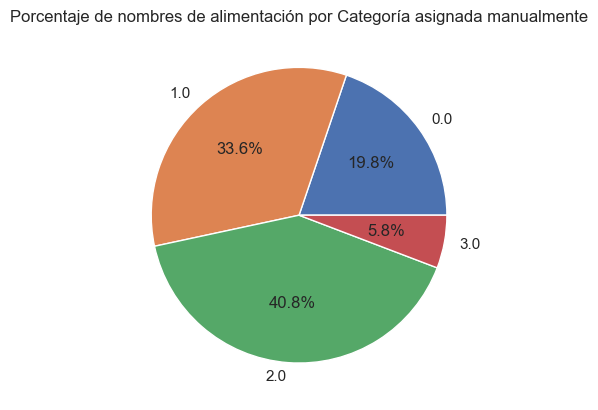

In [8]:
sizes_df = final_general_df.groupby(['dataset_year','Categoría']).size().reset_index(name='size')

fig, ax = plt.subplots()
ax.pie(sizes_df[sizes_df.dataset_year == 2024]['size'], labels=sizes_df[sizes_df.dataset_year == 2024]['Categoría'], autopct='%1.1f%%')
plt.title('Porcentaje de nombres de alimentación por Categoría asignada manualmente')
plt.show()


In [9]:
# Miramos los tamaños (o la cantidad de filas) antes de filtrar
final_general_df.groupby(['dataset_year', 'Categoría']).size()

dataset_year  Categoría
2010          0.0          1638
              1.0          5564
              2.0          5408
              3.0           962
2011          0.0          1638
              1.0          5564
              2.0          5408
              3.0           962
2012          0.0          1638
              1.0          5564
              2.0          5408
              3.0           962
2013          0.0          1690
              1.0          6058
              2.0          6630
              3.0          1014
2014          0.0          1690
              1.0          6058
              2.0          6630
              3.0          1014
2015          0.0          1690
              1.0          6058
              2.0          6630
              3.0          1014
2016          0.0          1690
              1.0          6058
              2.0          6630
              3.0          1014
2017          0.0          1690
              1.0          6058
              2.

In [10]:
# Filtraremos todas las filas que no sean categorizados como 1 en el dataset.

filtered_general_df = final_general_df[final_general_df['Categoría'] == 1]
filtered_general_df.head()

index     Nombre original      CCAA  PENETRACIÓN    PRECIO  \
2       2      T.HUEVOS UNDS.  T.ESPAÑA    70.682500  0.123097   
7       6                MIEL  T.ESPAÑA     6.459167  5.280797   
13     12  SALCHICHAS FRESCAS  T.ESPAÑA    12.725833  6.418962   
14     13        CARNE VACUNO  T.ESPAÑA    52.575000  9.027366   
18     17         CARNE POLLO  T.ESPAÑA    70.785000  4.015438   

    CONSUMOXCÁPITA  GASTOXCÁPITA  dataset_year  Categoría     Nombre Refinado  \
2       130.984434     16.123740          2011        1.0              Huevos   
7         0.438368      2.314934          2011        1.0                Miel   
13        0.648186      4.160681          2011        1.0  Salchichas frescas   
14        6.577153     59.374366          2011        1.0        Carne vacuno   
18       14.550497     58.426616          2011        1.0         Carne pollo   

               Categoría comida  
2   Lácteos, Derivados y Huevos  
7            Otros/Complementos  
13                       Carnes  
14                       Carnes  
18                       Carnes

El análisis a realizar:
- Top 10  con subplots para cada variable en cada categoría comida
- Top 10 en crecimiento anual


### 2.1 Top 10 alimentos en cada categoría de comida 

In [70]:
spain_df = filtered_general_df[filtered_general_df['CCAA'] == 'T.ESPAÑA'] # Solo necesitamos los datos de España

Definimos una función para poder graficar luego

In [66]:
sns.set_palette('tab10')
def plot_top10(metric):
    df = spain_df.groupby(['Categoría comida', 'Nombre Refinado'])[metric].mean().reset_index().sort_values(by=metric, ascending=False).groupby('Categoría comida').head(10).sort_values(by=['Categoría comida', metric], ascending=False)

    num_categories = len(df['Categoría comida'].unique())

    fig, axes = plt.subplots(4,3, figsize=(18, 20)) 
    axes = axes.flatten()

    for idx, group in enumerate(df['Categoría comida'].unique()):
        group_df = df[df['Categoría comida'] == group]  
        sns.barplot(data=group_df, x='Nombre Refinado', y=metric, hue='Nombre Refinado', ax=axes[idx])
        
        axes[idx].set_title(f"Top 10 de {group} por {metric}")
        axes[idx].tick_params(axis='x', rotation=80)
        axes[idx].set_xlabel('')
        
        # Añado texto a las barras
        for p in axes[idx].patches:
            axes[idx].annotate(f'{p.get_height():.2f}', 
                               (p.get_x() + p.get_width() / 2., p.get_height()), 
                               xytext=(0, 5), 
                               textcoords='offset points',
                               ha='center', va='bottom', fontsize=10, color='black')

    for j in range(num_categories, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


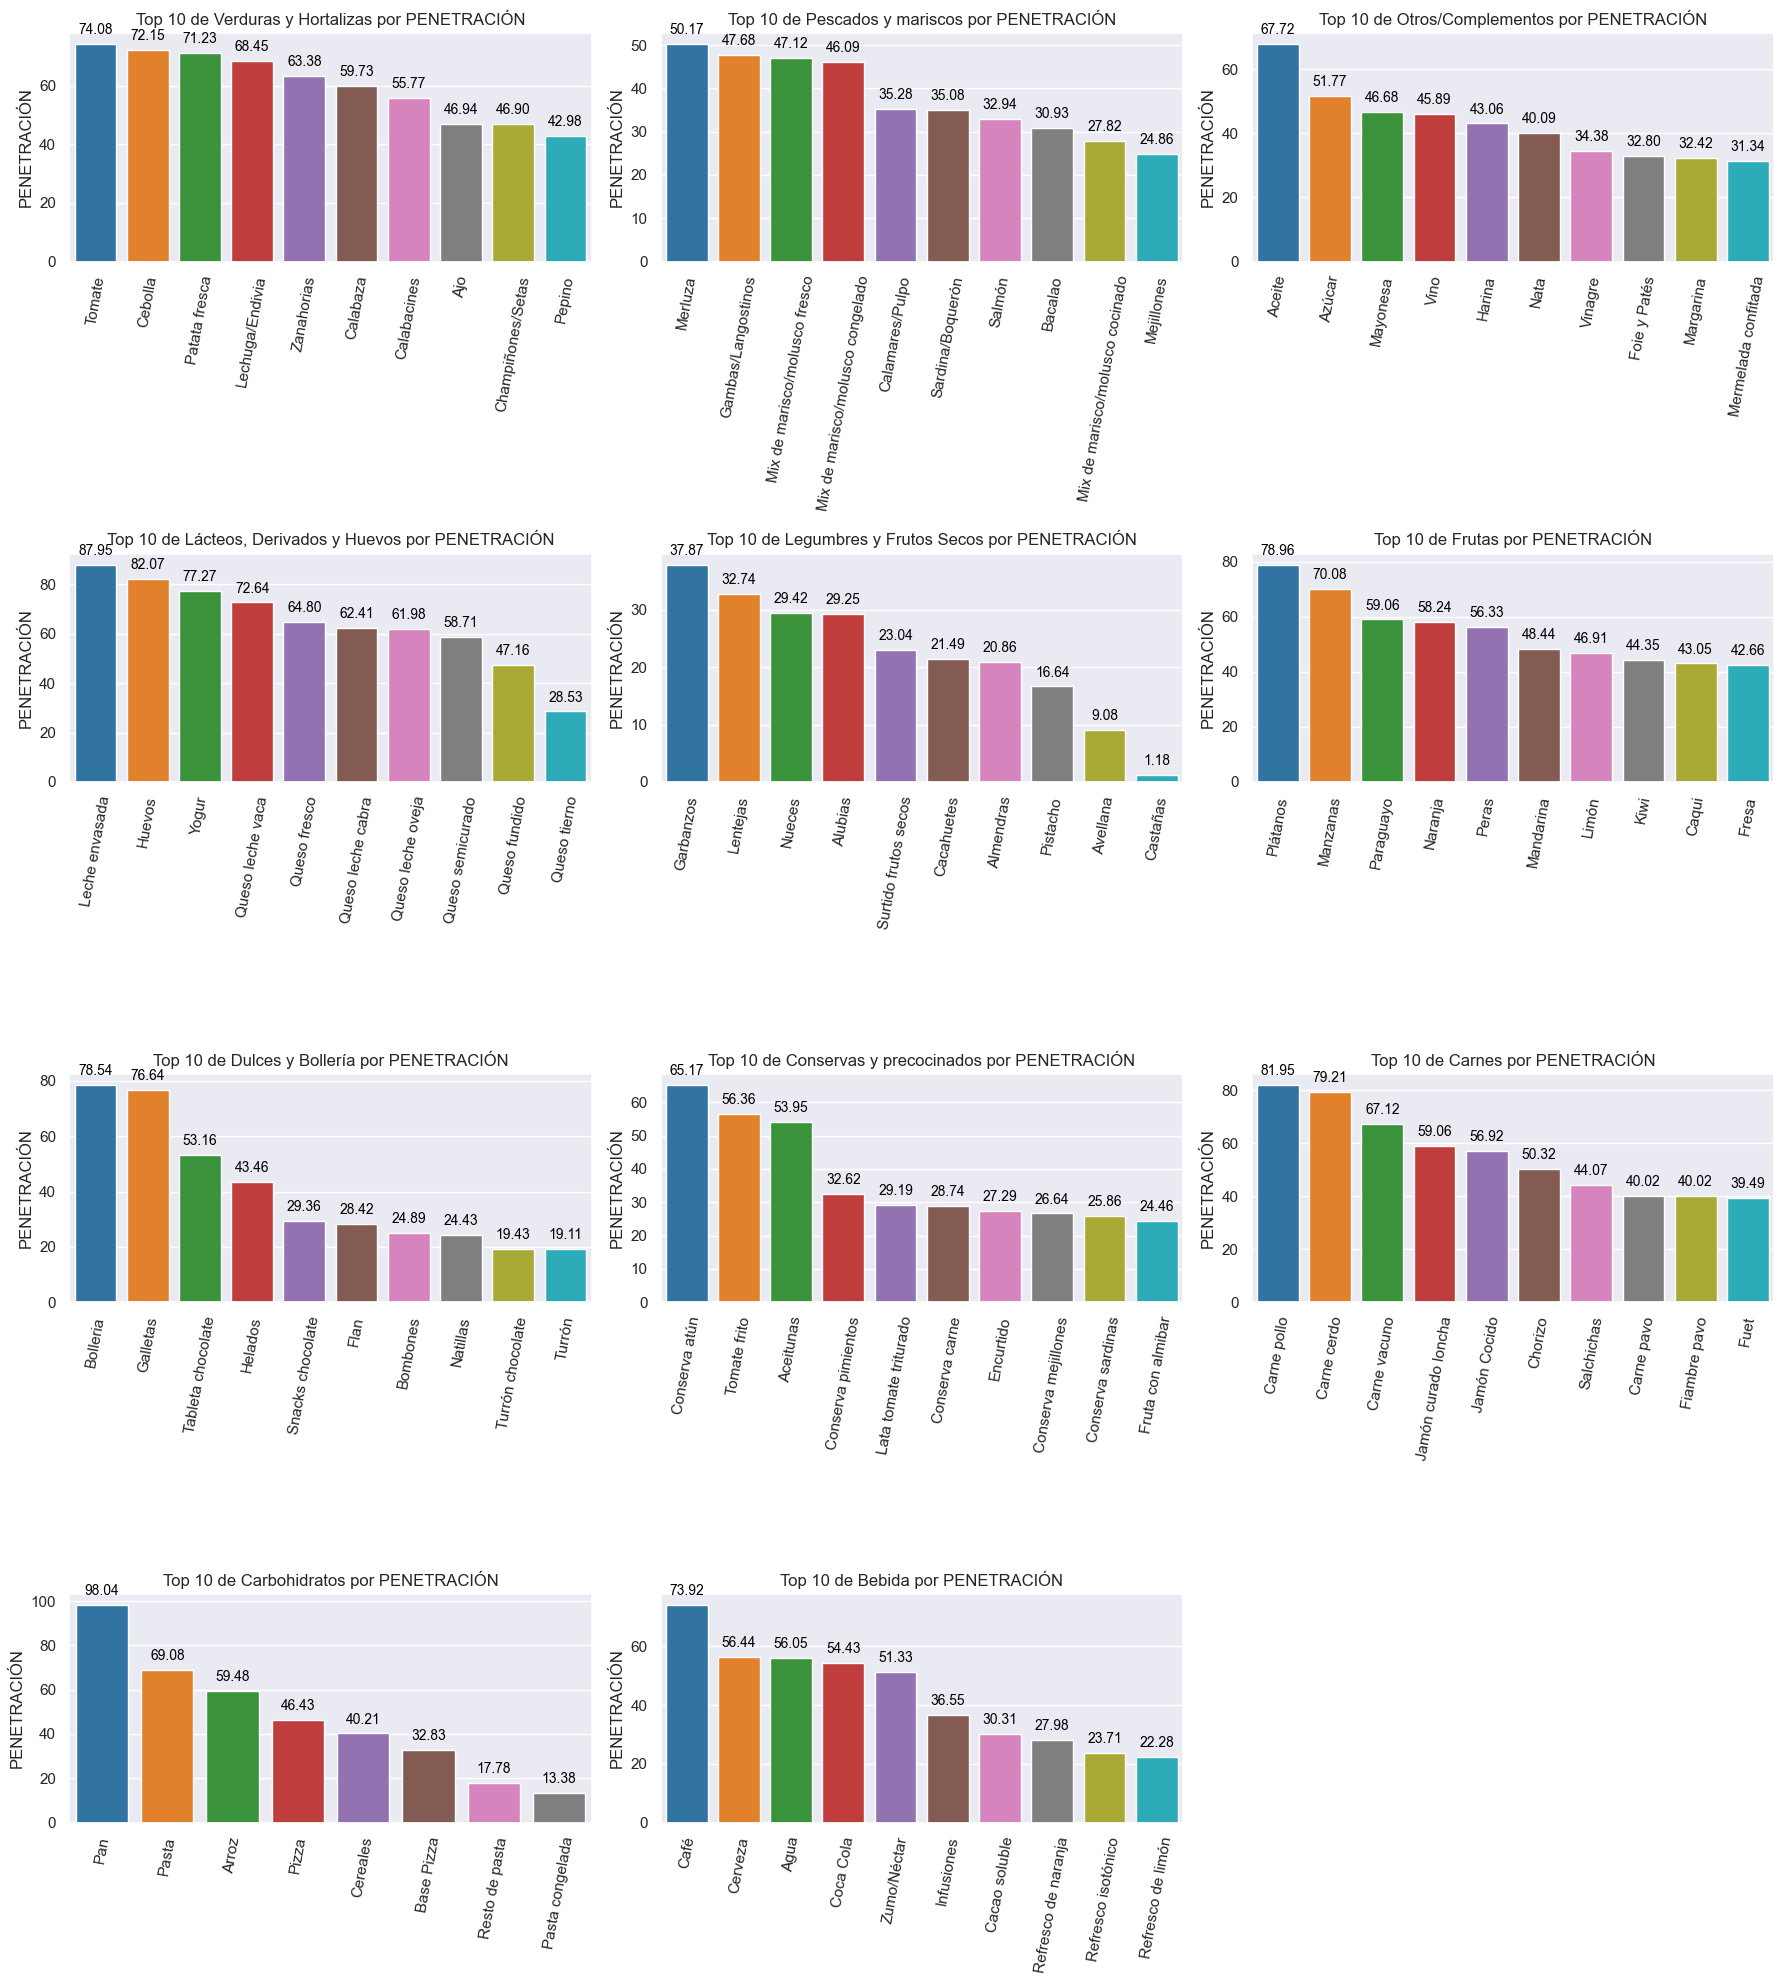

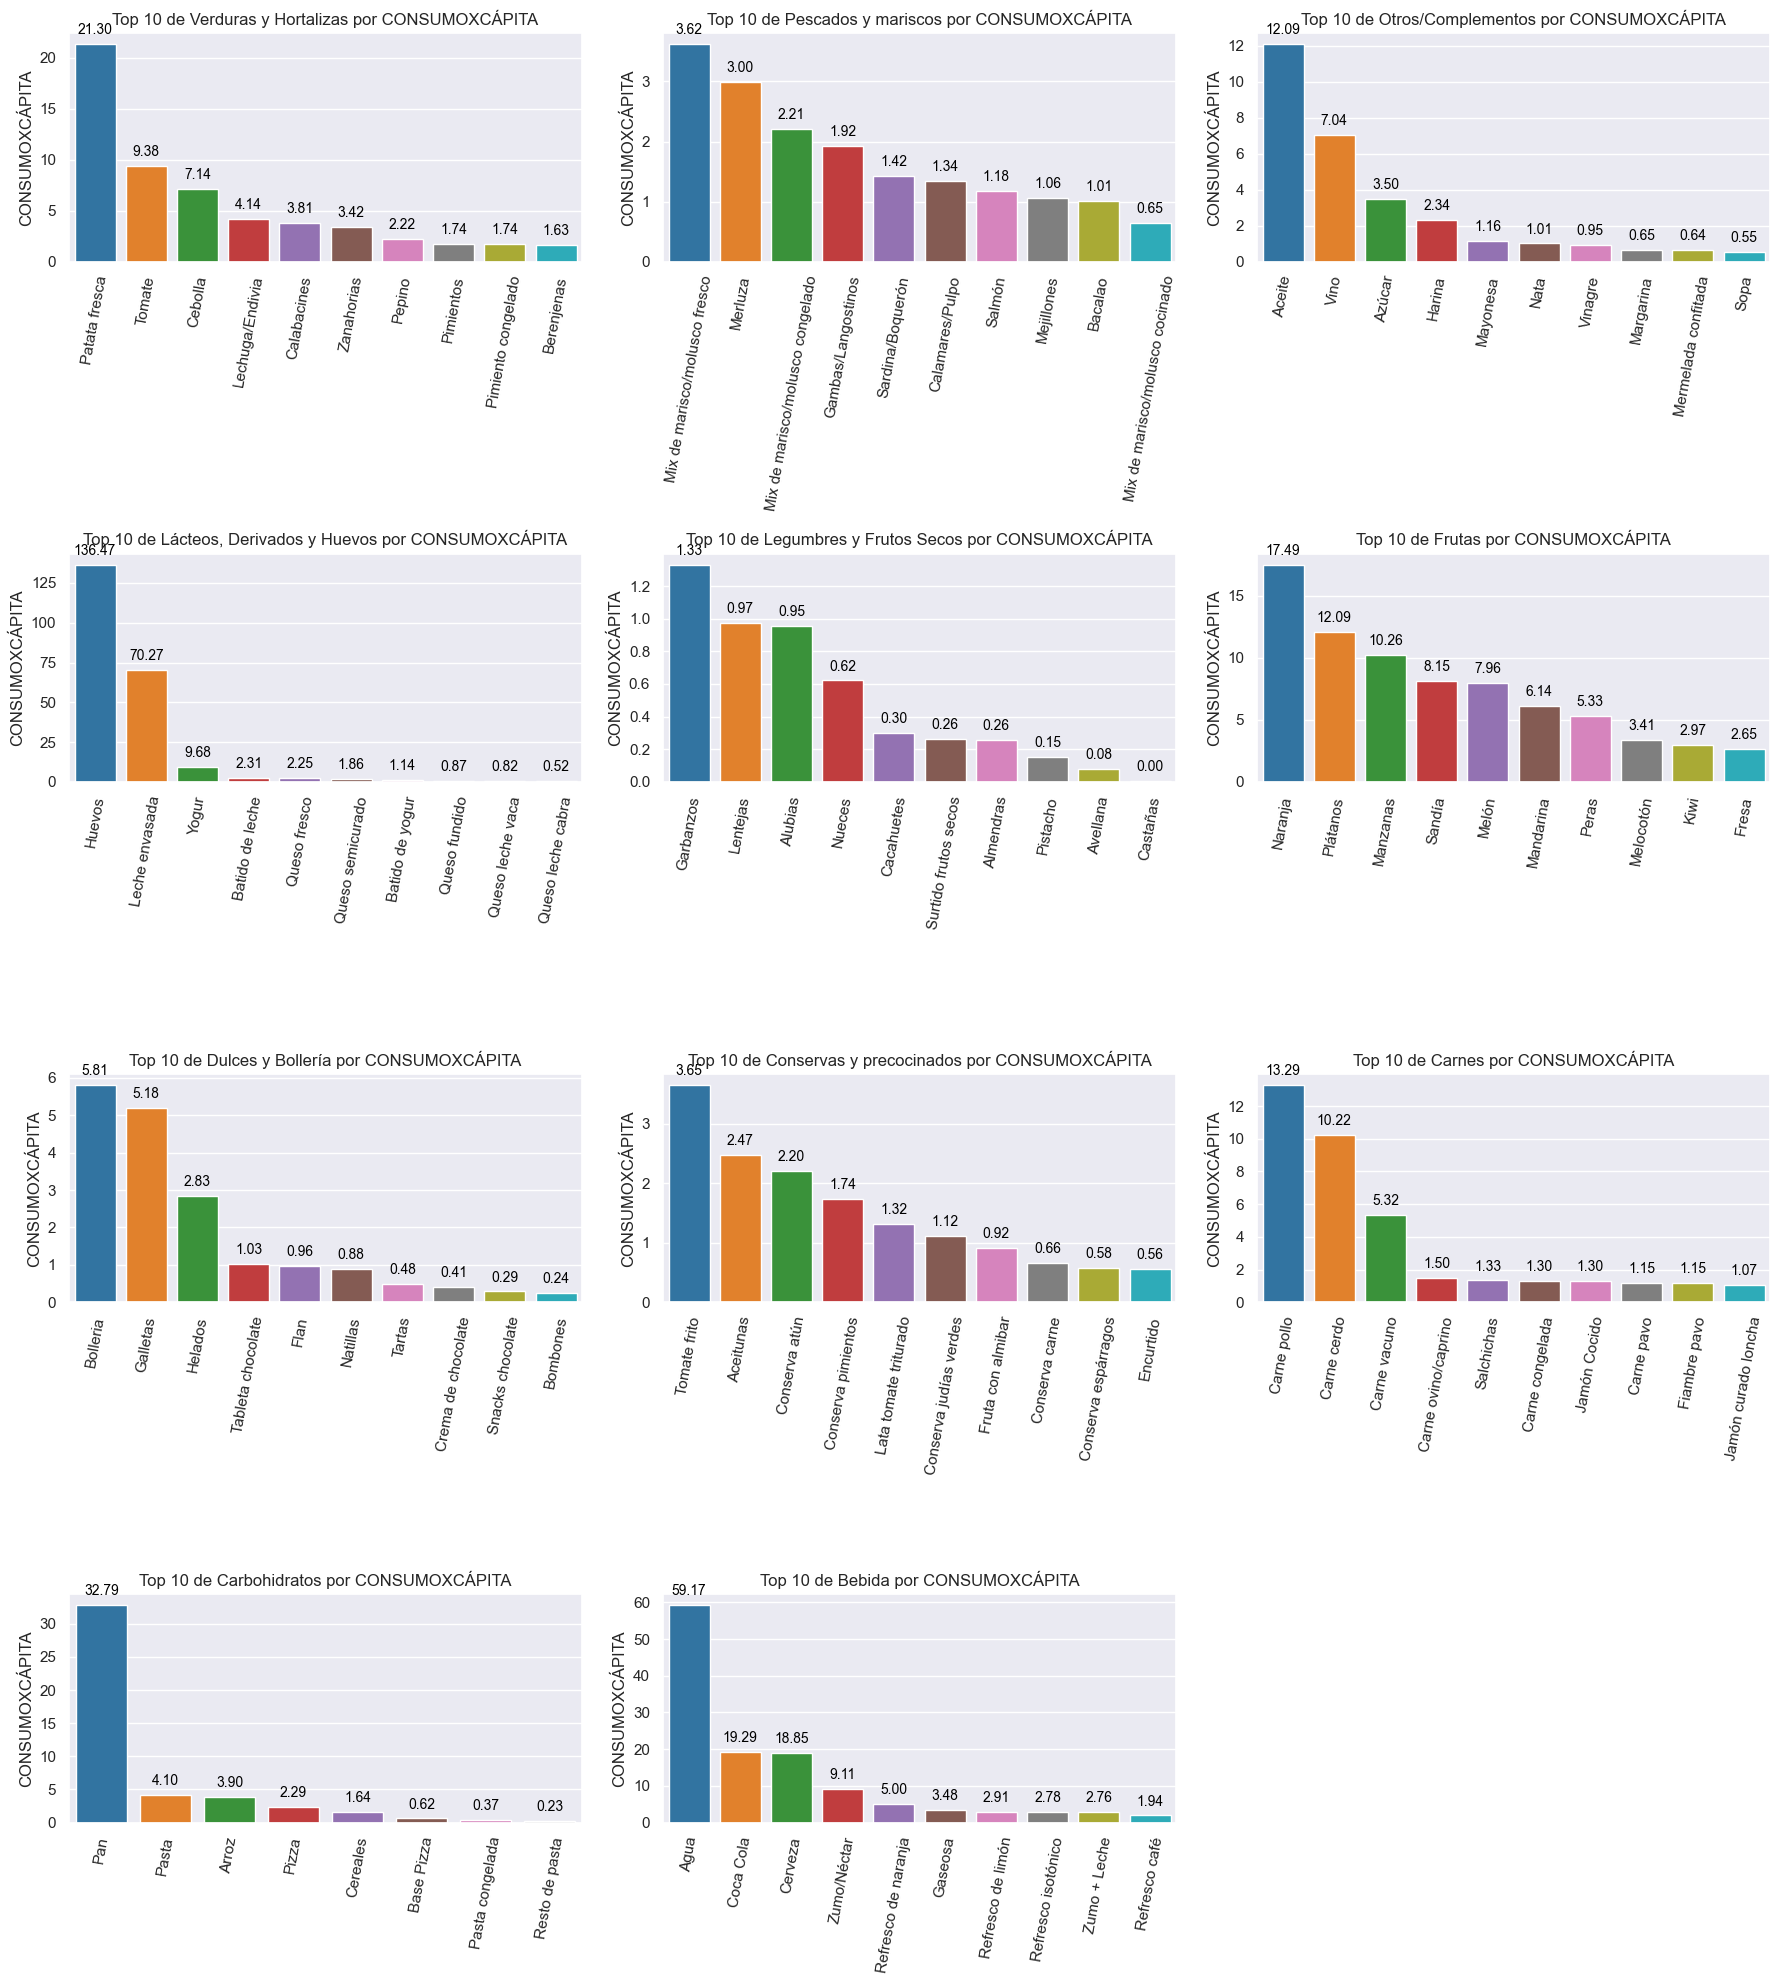

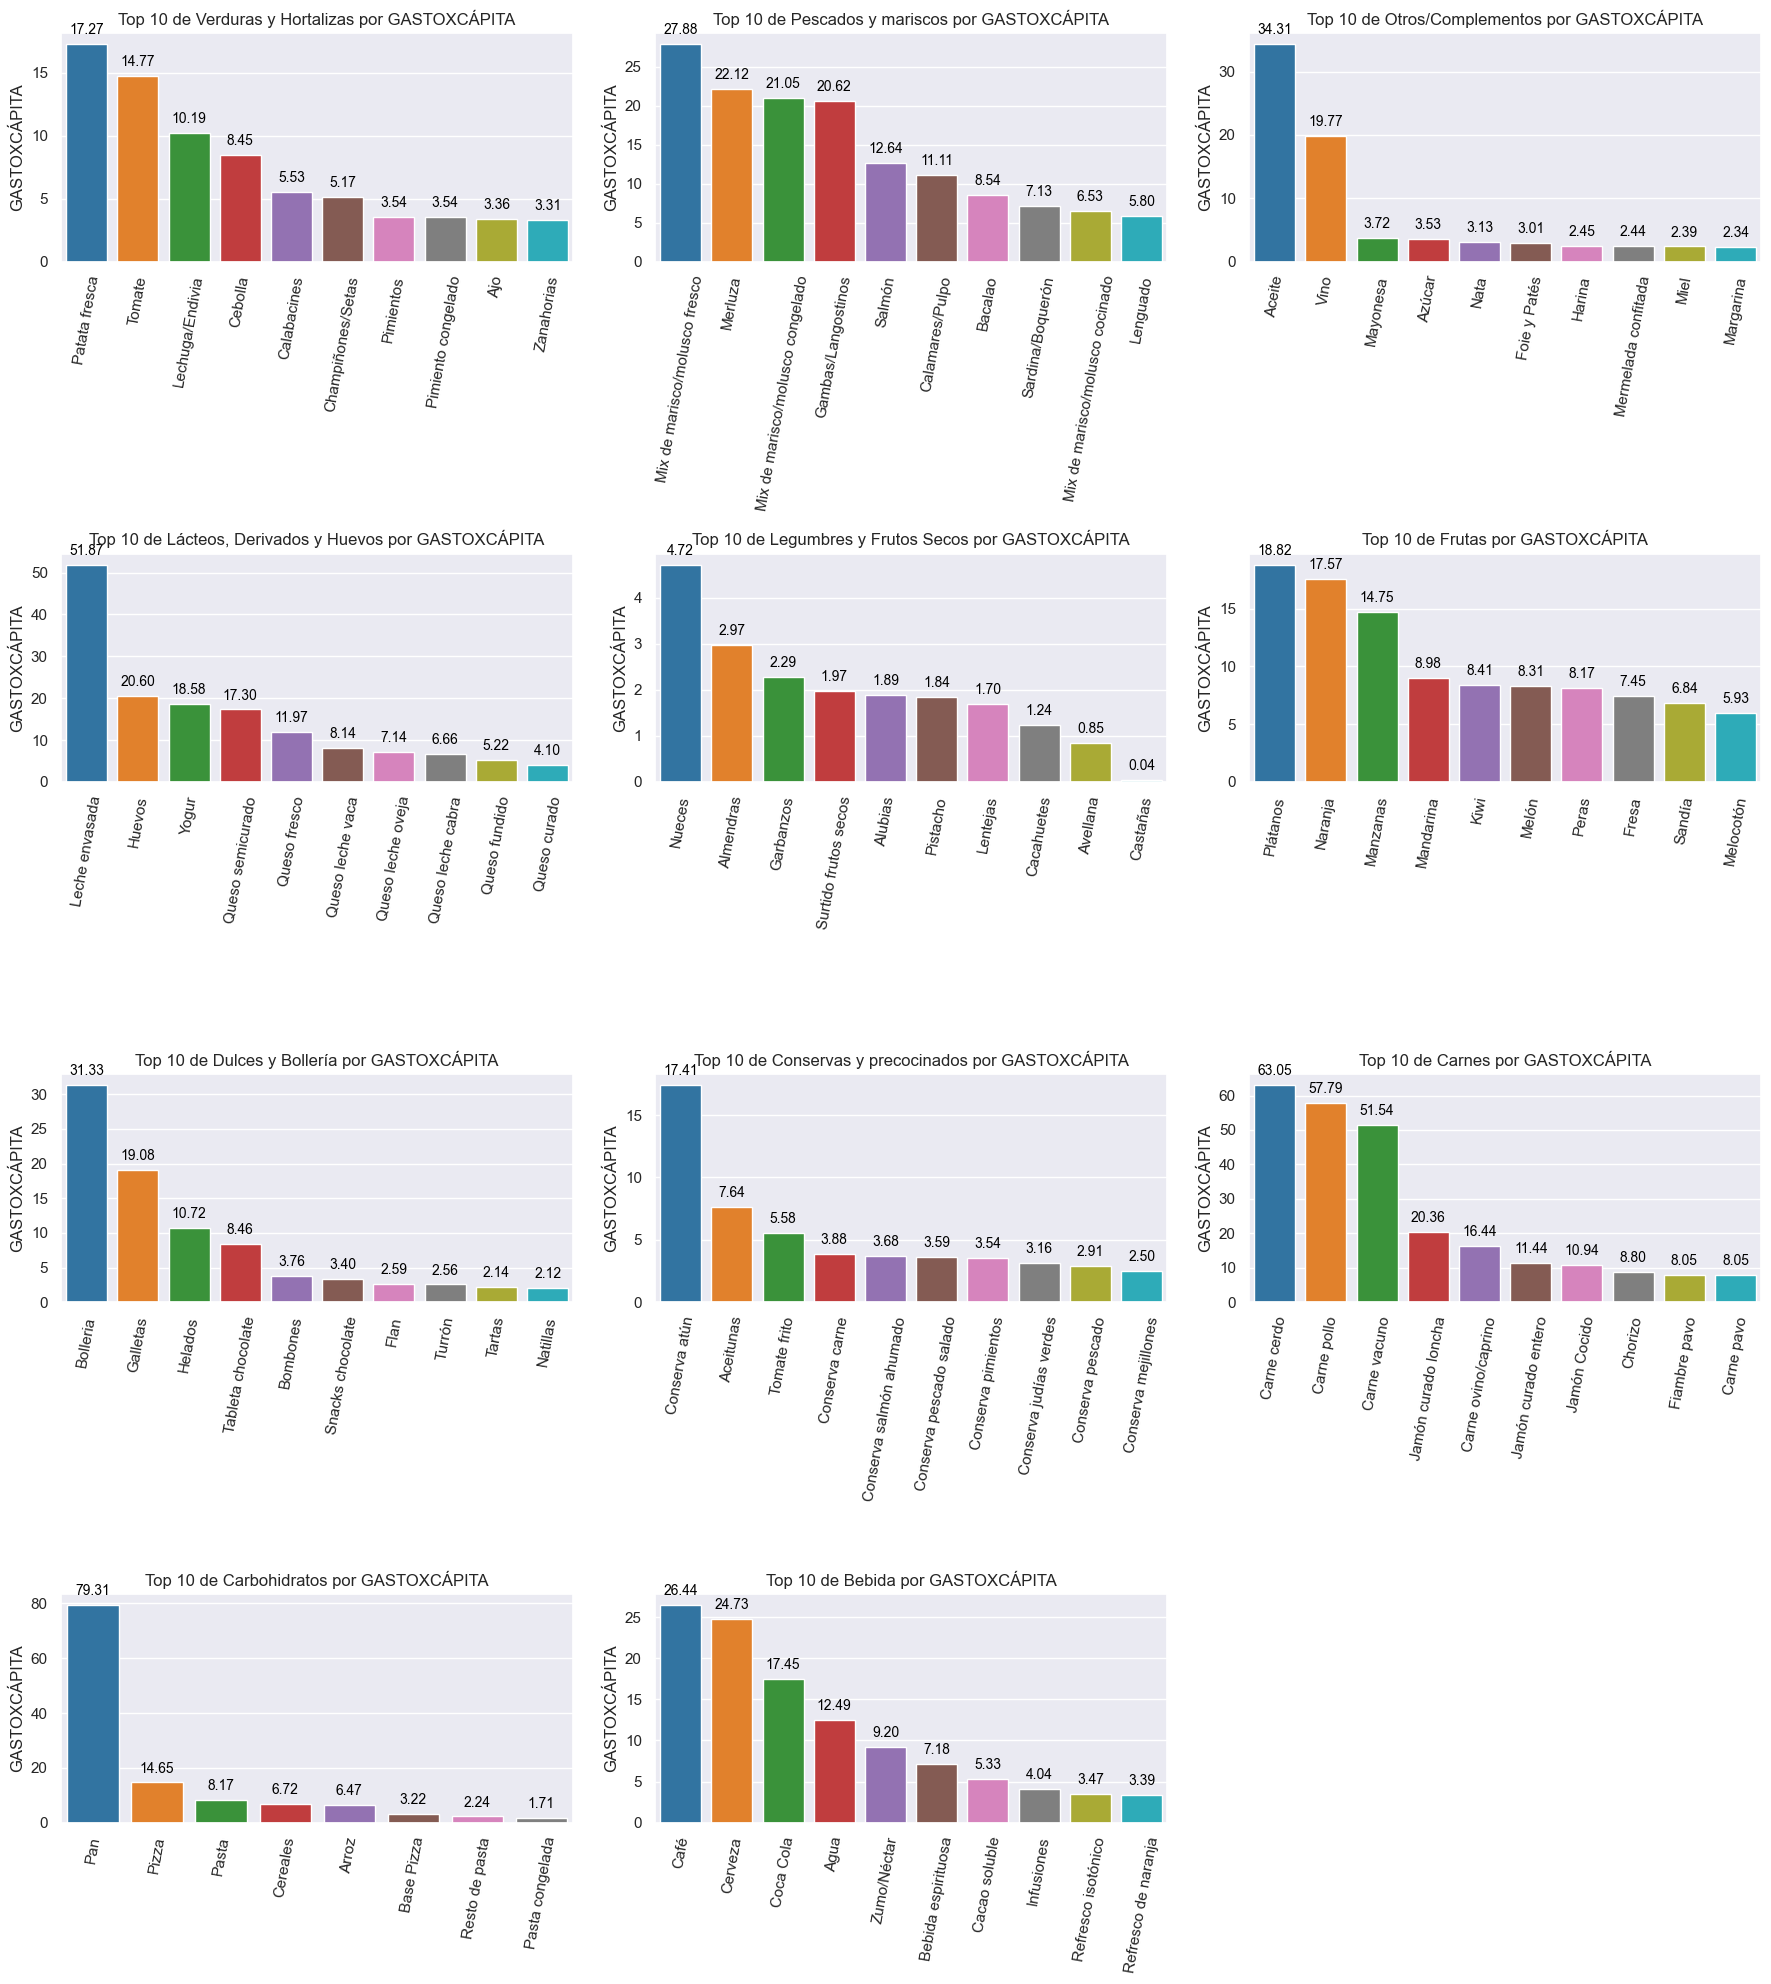

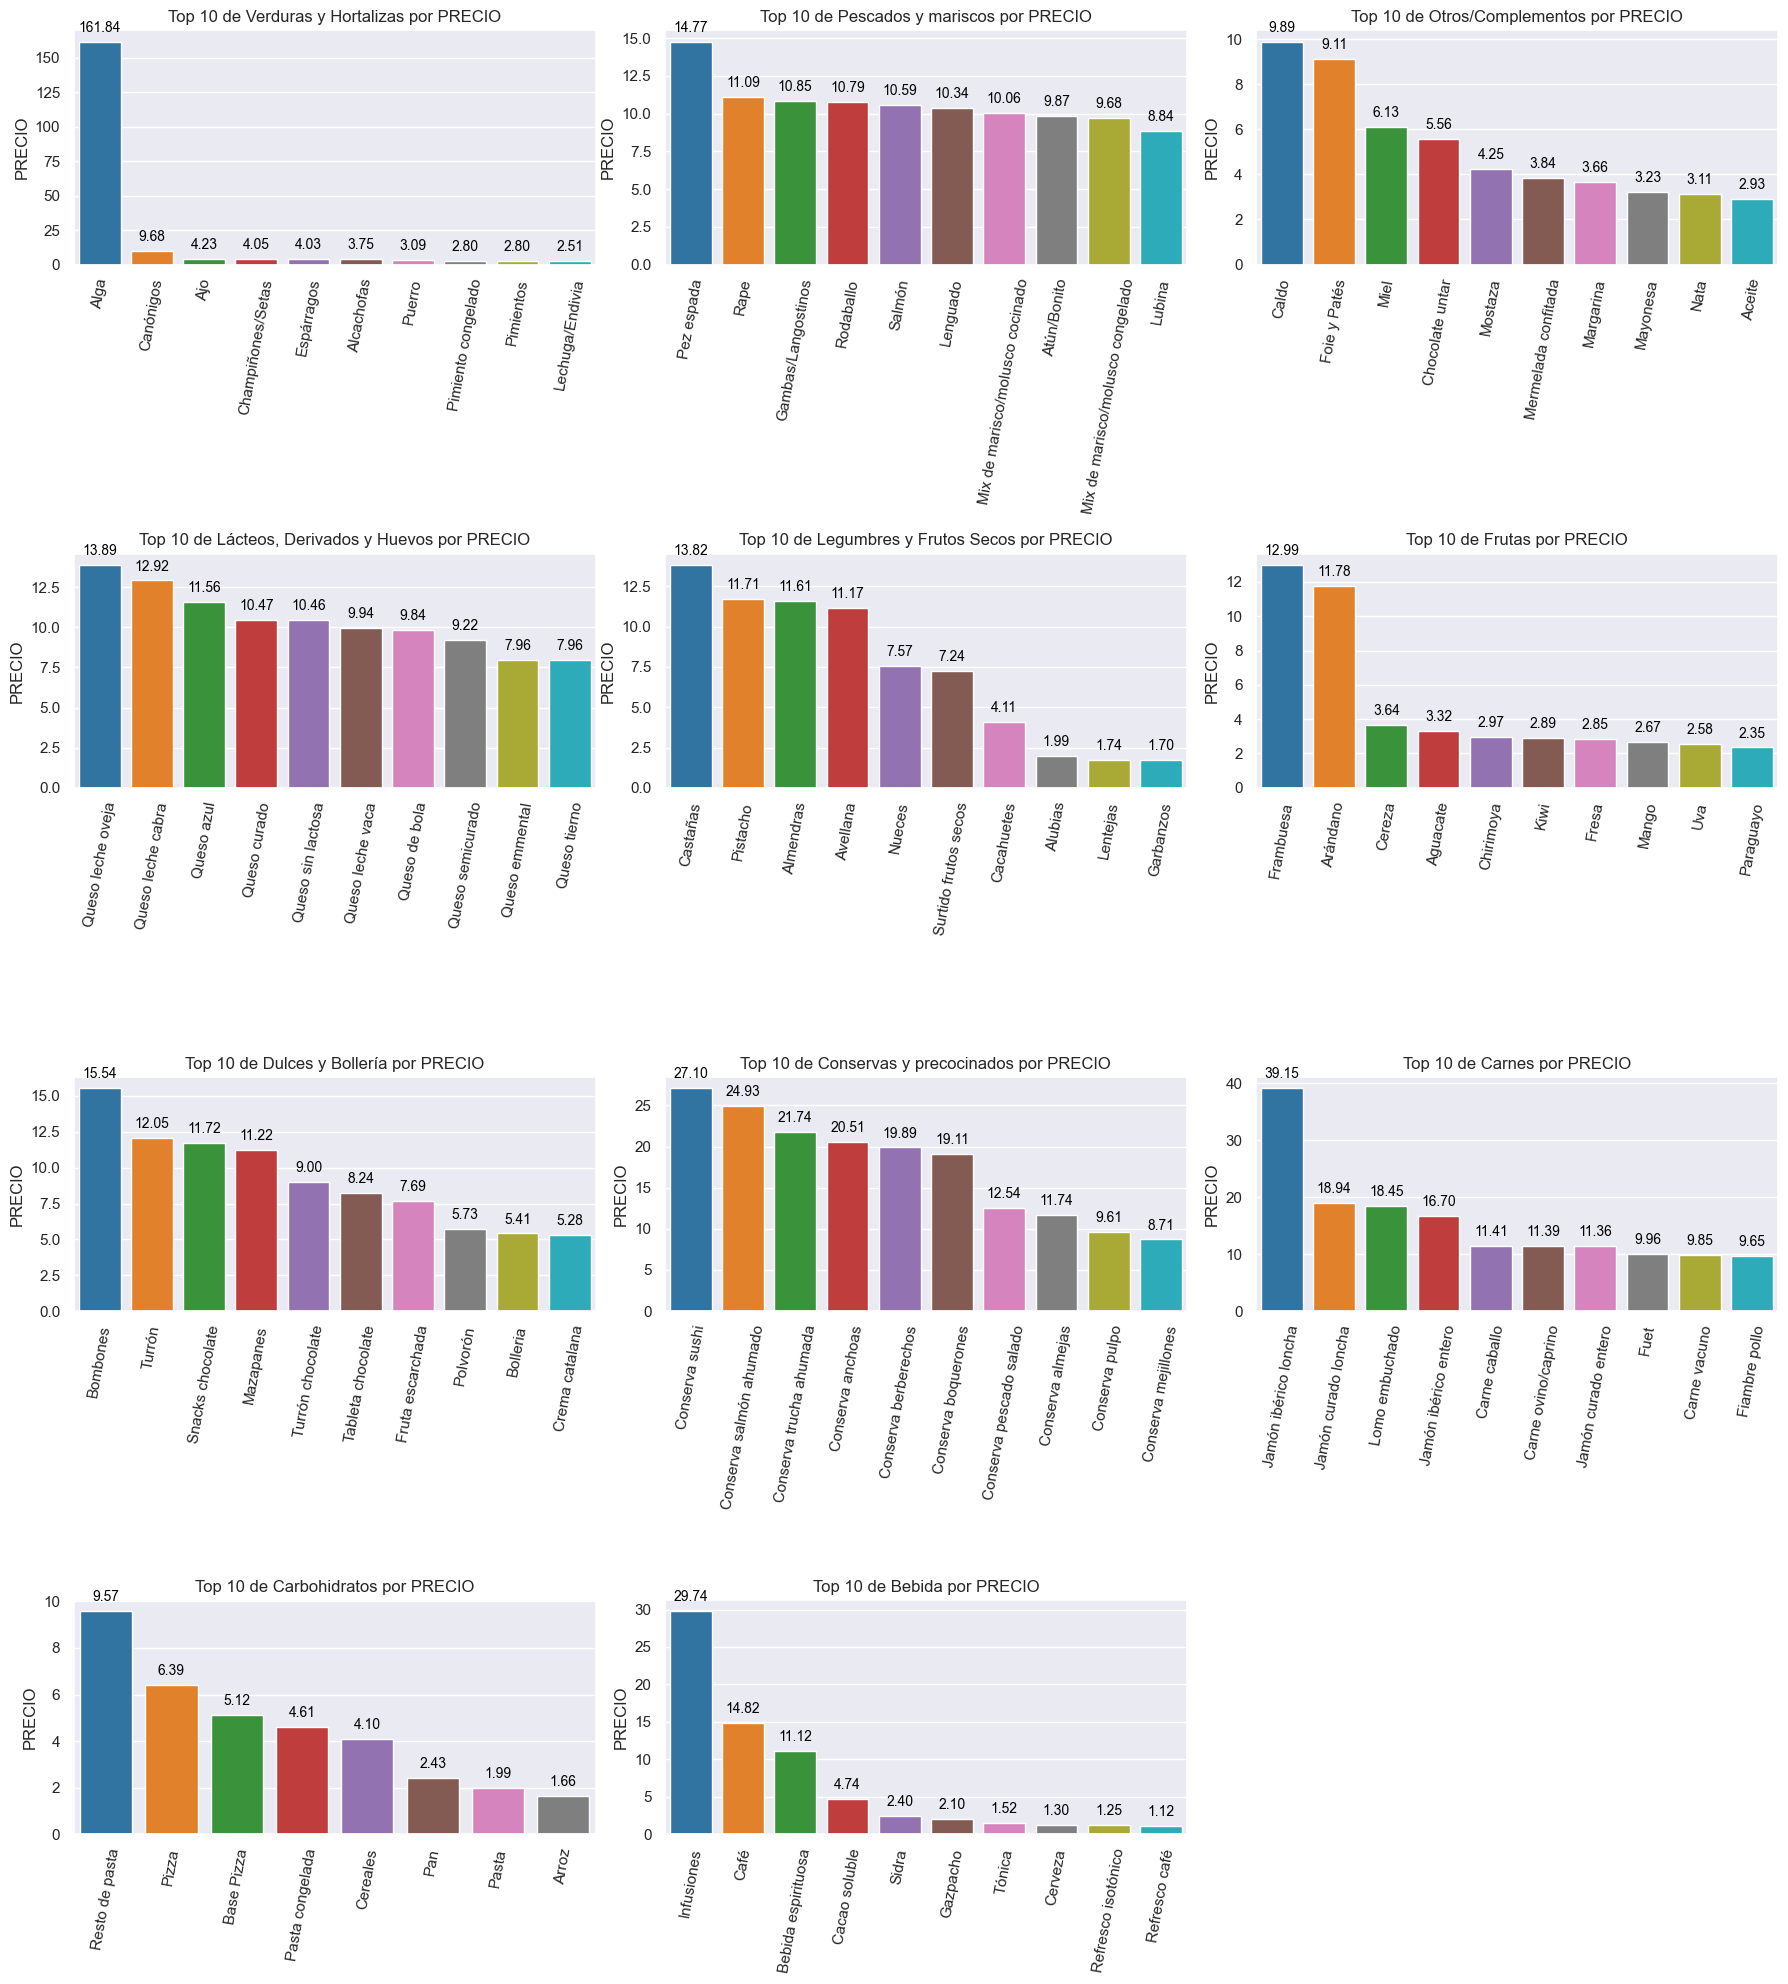

In [68]:
plot_top10('PENETRACIÓN')
plot_top10('CONSUMOXCÁPITA')
plot_top10('GASTOXCÁPITA')
plot_top10('PRECIO')

### 2.2 Top 10 alimentos con mayor crecimiento anual

En este apartado procedemos a analizar también los productos que más crecimiento anual han tenido a lo largo de los años. El dataset contiene datos desde el 2010.

In [ ]:
#Primero tenemos que hacer pivot en el DataFrame para obtener el formato correcto para calcular el crecimiento porcentual anual

#Pivotamos
pivoted_spain_df = spain_df.pivot_table(index=['Categoría comida' , 'Nombre Refinado'], columns='dataset_year', values=['PENETRACIÓN','PRECIO','CONSUMOXCÁPITA','GASTOXCÁPITA'])
pivoted_spain_df

CONSUMOXCÁPITA                        \
dataset_year                                       2010       2011       2012   
Categoría comida      Nombre Refinado                                           
Bebida                Agua                    52.918334  51.484357  51.586723   
                      Bebida espirituosa            NaN        NaN        NaN   
                      Cacao soluble            1.246901   1.231952   1.204952   
                      Café                     1.670012   1.709934   1.747373   
                      Cerveza                 16.574741  17.114952  17.645661   
...                                                 ...        ...        ...   
Verduras y Hortalizas Pimientos                1.684914   1.779081   1.798656   
                      Puerro                        NaN        NaN        NaN   
                      Rábanos                       NaN        NaN        NaN   
                      Tomate                   9.625941  10.214267   9.978648   
                      Zanahorias               3.410732   3.449270   3.554690   

                                                                           \
dataset_year                                   2013       2014       2015   
Categoría comida      Nombre Refinado                                       
Bebida                Agua                52.030002  52.583143  56.464146   
                      Bebida espirituosa   0.000000   0.000000   0.726808   
                      Cacao soluble        1.275934   1.311156   1.357544   
                      Café                 1.803710   1.776159   1.730230   
                      Cerveza             17.803894  18.176185  18.313668   
...                                             ...        ...        ...   
Verduras y Hortalizas Pimientos            1.843435   1.827894   1.695653   
                      Puerro               0.000000   0.000000   0.000000   
                      Rábanos                   NaN        NaN        NaN   
                      Tomate              10.144117   9.791749   9.693700   
                      Zanahorias           3.639527   3.630203   3.416925   

                                                                           \
dataset_year                                   2016       2017       2018   
Categoría comida      Nombre Refinado                                       
Bebida                Agua                60.323092  61.373219  62.964332   
                      Bebida espirituosa   0.817508   0.741540   0.731032   
                      Cacao soluble        1.314252   1.213538   1.207987   
                      Café                 1.775427   1.698685   1.725361   
                      Cerveza             18.713479  18.503891  18.196952   
...                                             ...        ...        ...   
Verduras y Hortalizas Pimientos            1.771071   1.682734   1.773106   
                      Puerro               0.000000   0.000000   0.000000   
                      Rábanos                   NaN        NaN        NaN   
                      Tomate               9.840225   9.040444   9.254869   
                      Zanahorias           3.495871   3.244516   3.261782   

                                                     ...     PRECIO  \
dataset_year                                   2019  ...       2015   
Categoría comida      Nombre Refinado                ...              
Bebida                Agua                61.017904  ...   0.208597   
                      Bebida espirituosa   0.709038  ...  10.489279   
                      Cacao soluble        1.094962  ...   4.437272   
                      Café                 1.739047  ...  14.021726   
                      Cerveza             18.105728  ...   1.186006   
...                                             ...  ...        ...   
Verduras y Hortalizas Pimientos            1.737157  ...   2.645117   
                      Puerro          

In [141]:
def plot_top5_growth(metric):

    metric_base = pivoted_spain_df[metric][2010]
    metric_change_vs_base = (pivoted_spain_df[metric].divide(metric_base, axis=0) - 1) * 100
    metric_change_vs_base = metric_change_vs_base.round(2).reset_index()


    melted_df = pd.melt(
        metric_change_vs_base,
        id_vars=['Categoría comida', 'Nombre Refinado'],
        value_vars=metric_change_vs_base.columns[3:],
        var_name='dataset_year',
        value_name=metric
    )


    top5_crecimiento = (
        melted_df
        .groupby(['Categoría comida', 'Nombre Refinado'])[metric]
        .mean()
        .reset_index()
        .sort_values(by=metric, ascending=False)
        .groupby('Categoría comida')
        .head(5)
    )


    unique_categories = top5_crecimiento['Categoría comida'].unique()
    num_plots = len(unique_categories)
    fig, axs = plt.subplots(4, 3, figsize=(20, 15))
    axs = axs.flatten()  


    for i, grupo in enumerate(unique_categories):
        ax = axs[i]
        productos = top5_crecimiento[top5_crecimiento['Categoría comida'] == grupo]['Nombre Refinado']
        data_plot = melted_df[melted_df['Nombre Refinado'].isin(productos)]

        sns.lineplot(data=data_plot, x='dataset_year', y=metric, hue='Nombre Refinado', ax=ax)
        ax.set_title(f'{grupo}')
        ax.set_ylabel(metric)
        ax.set_xlabel('Año')
        ax.legend(loc='upper left', fontsize='small', bbox_to_anchor=(1.01, 1.02))

    for j in range(i+1, len(axs)):
        fig.delaxes(axs[j])

    fig.suptitle(f'Top 5 productos con mayor crecimiento por categoría ({metric})', fontsize=16)
    plt.tight_layout()
    plt.show()


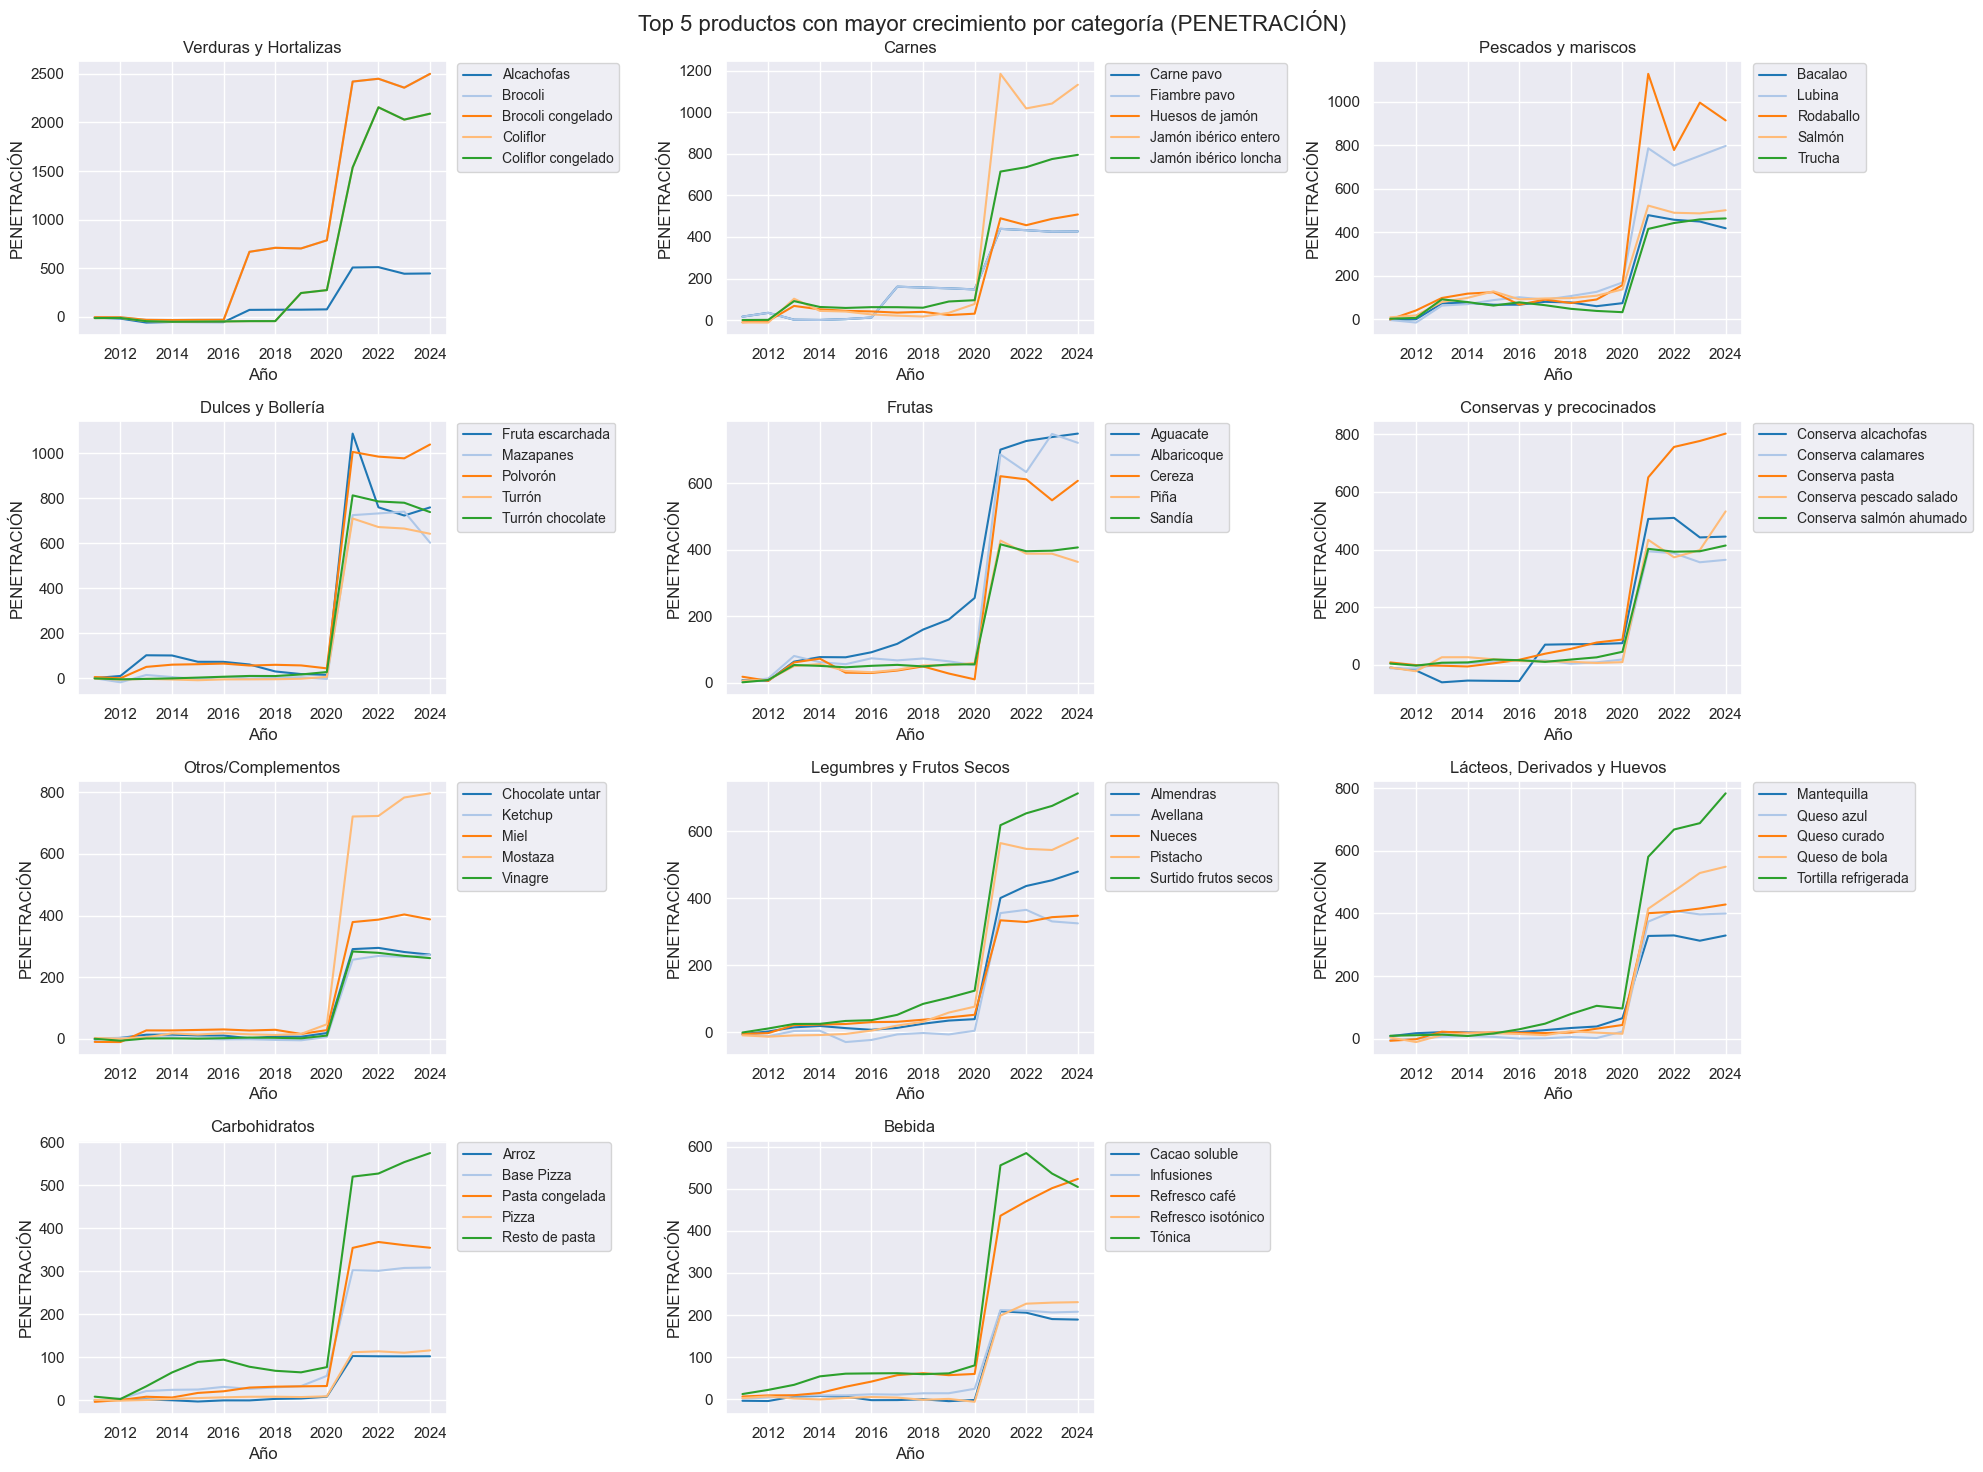

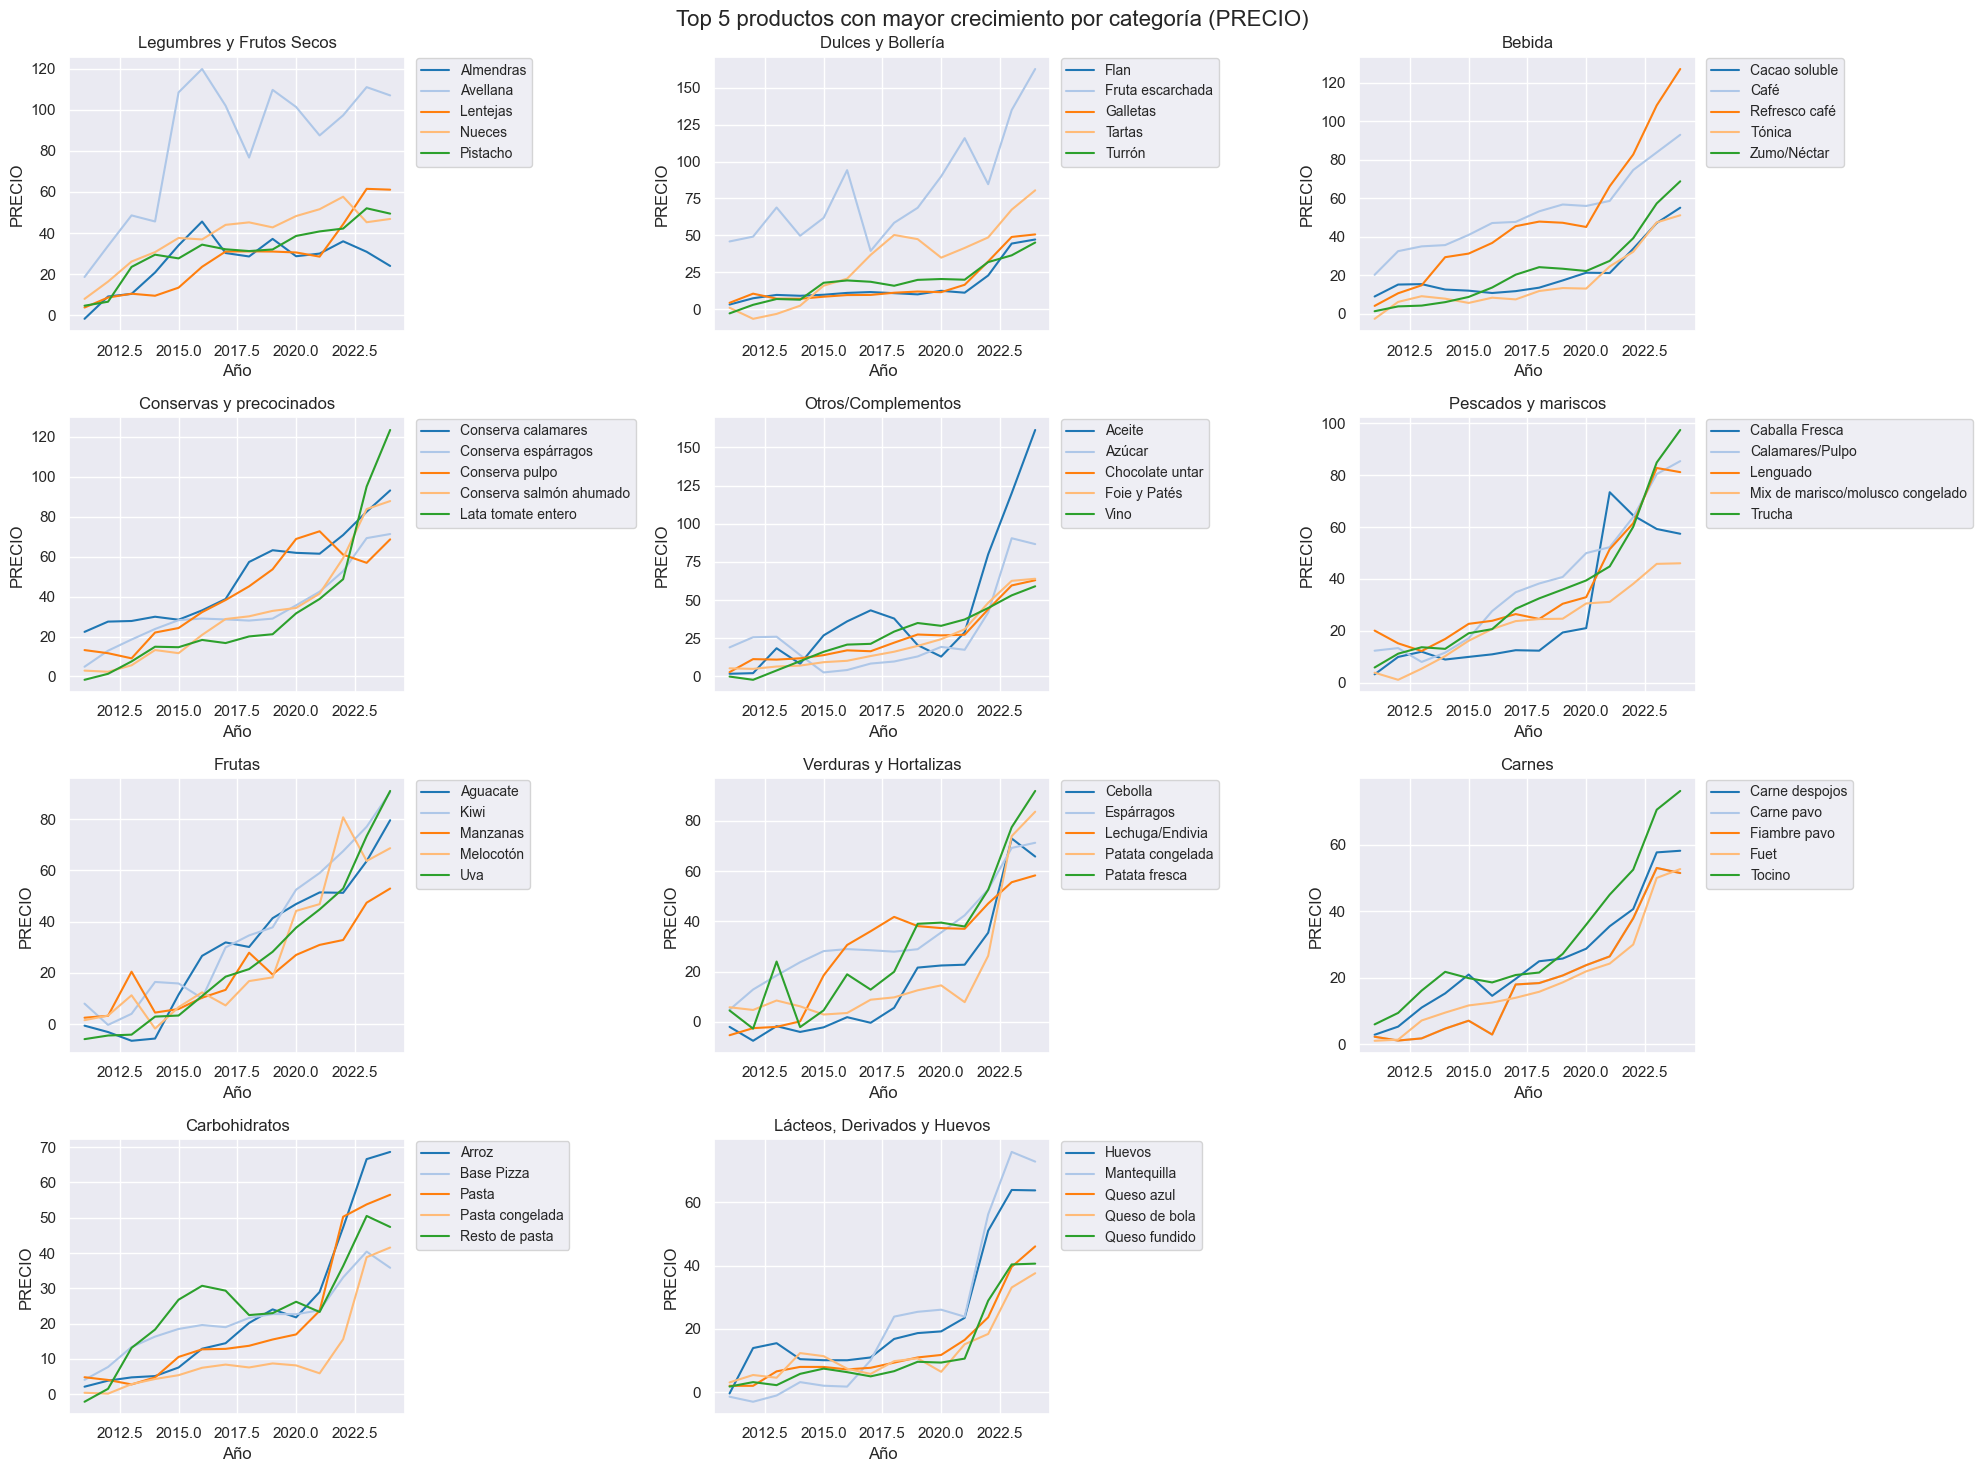

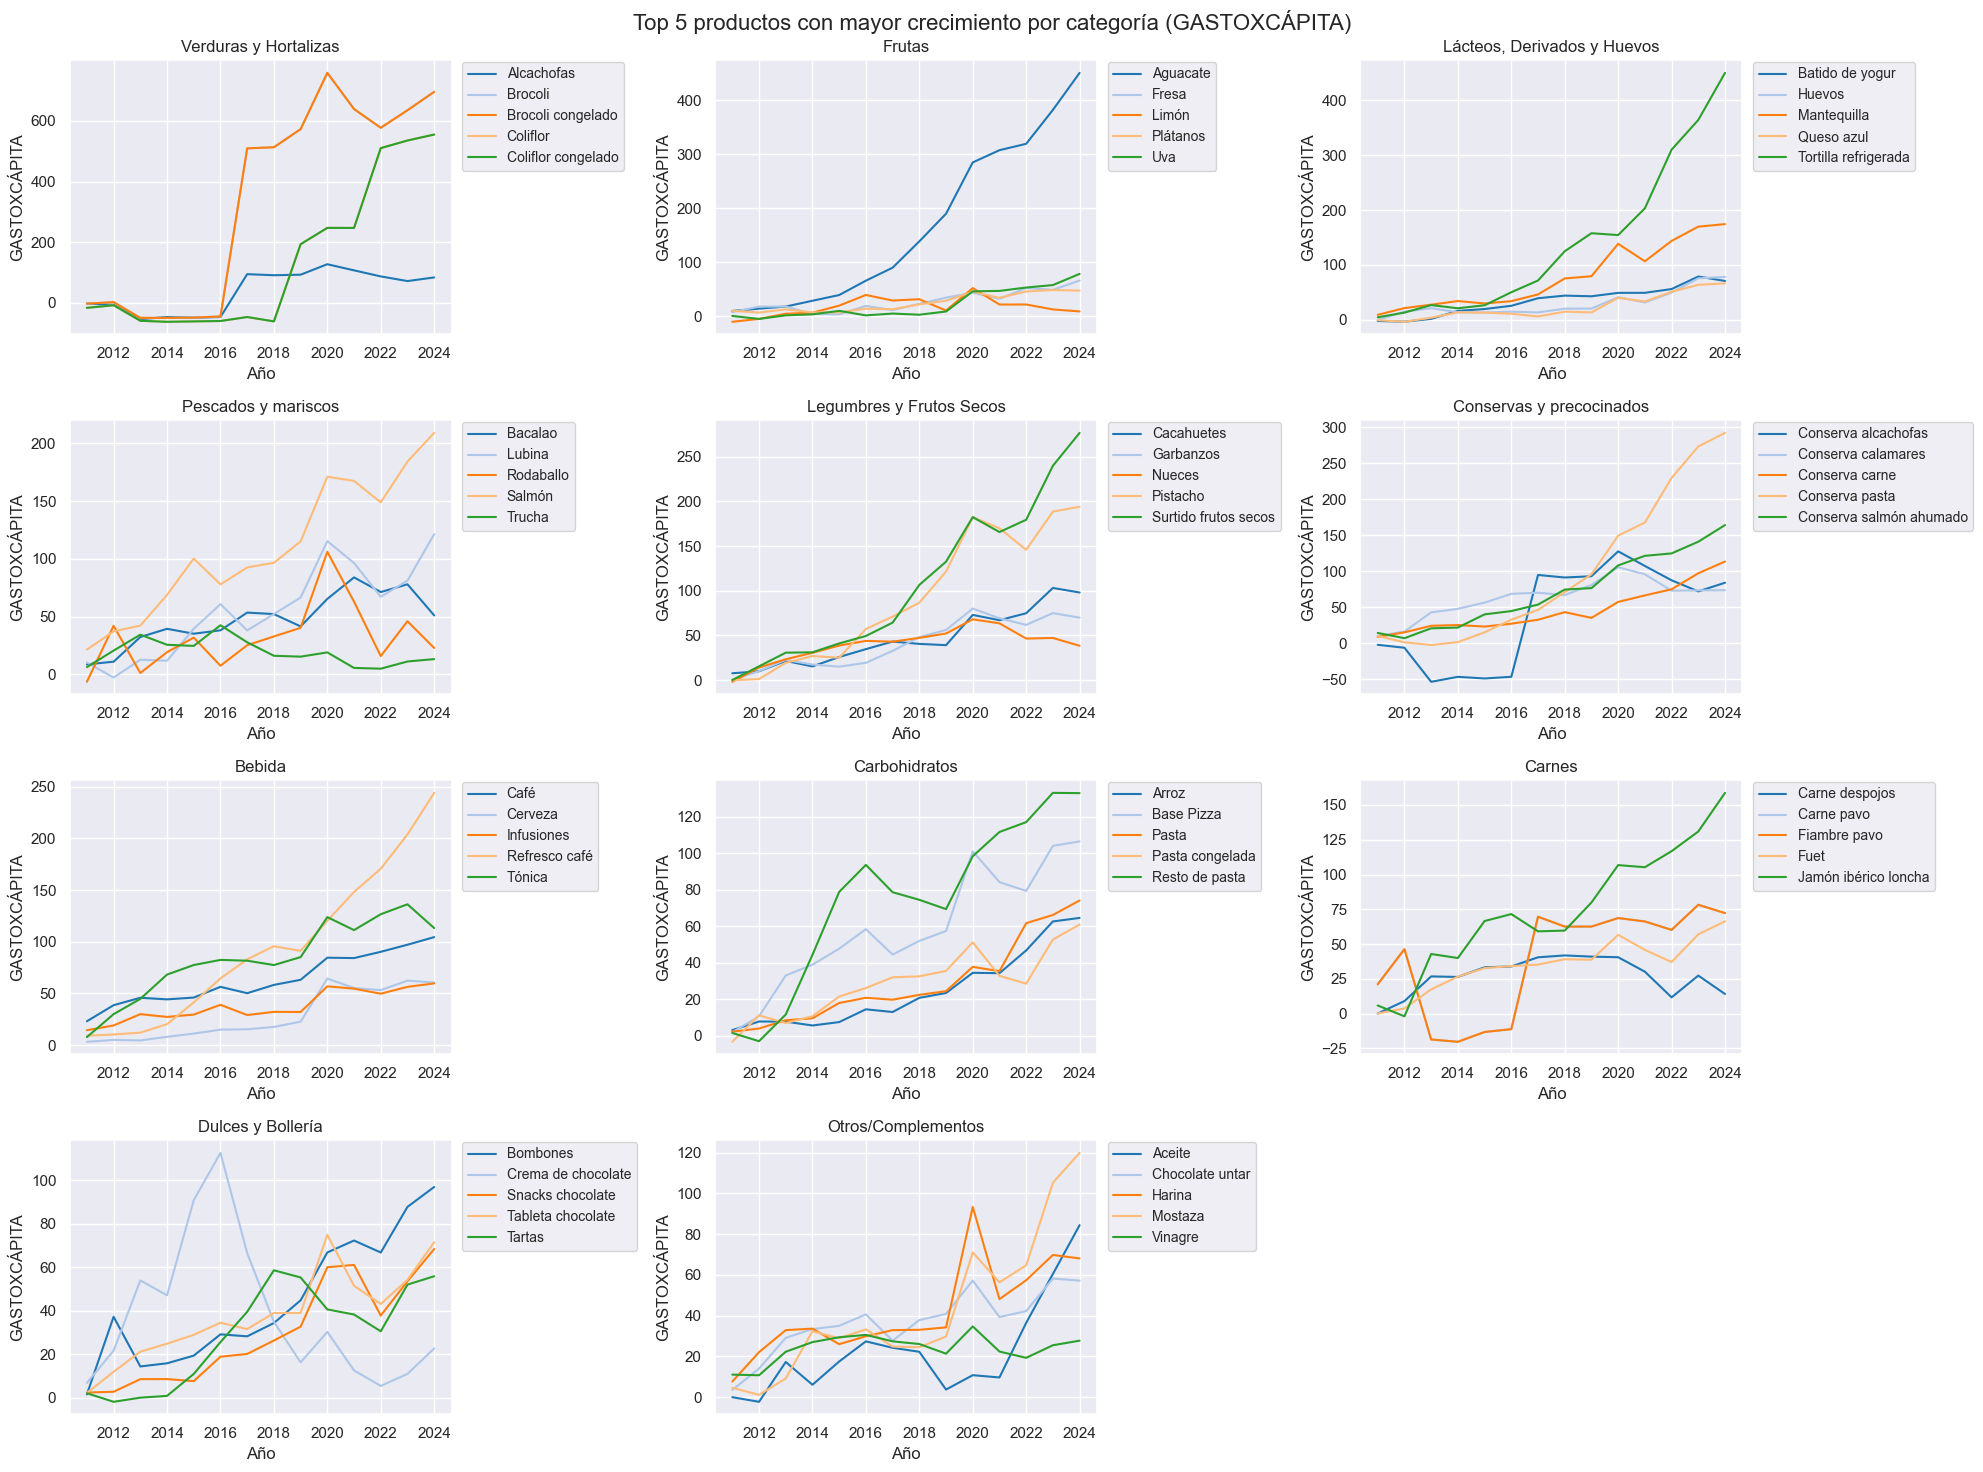

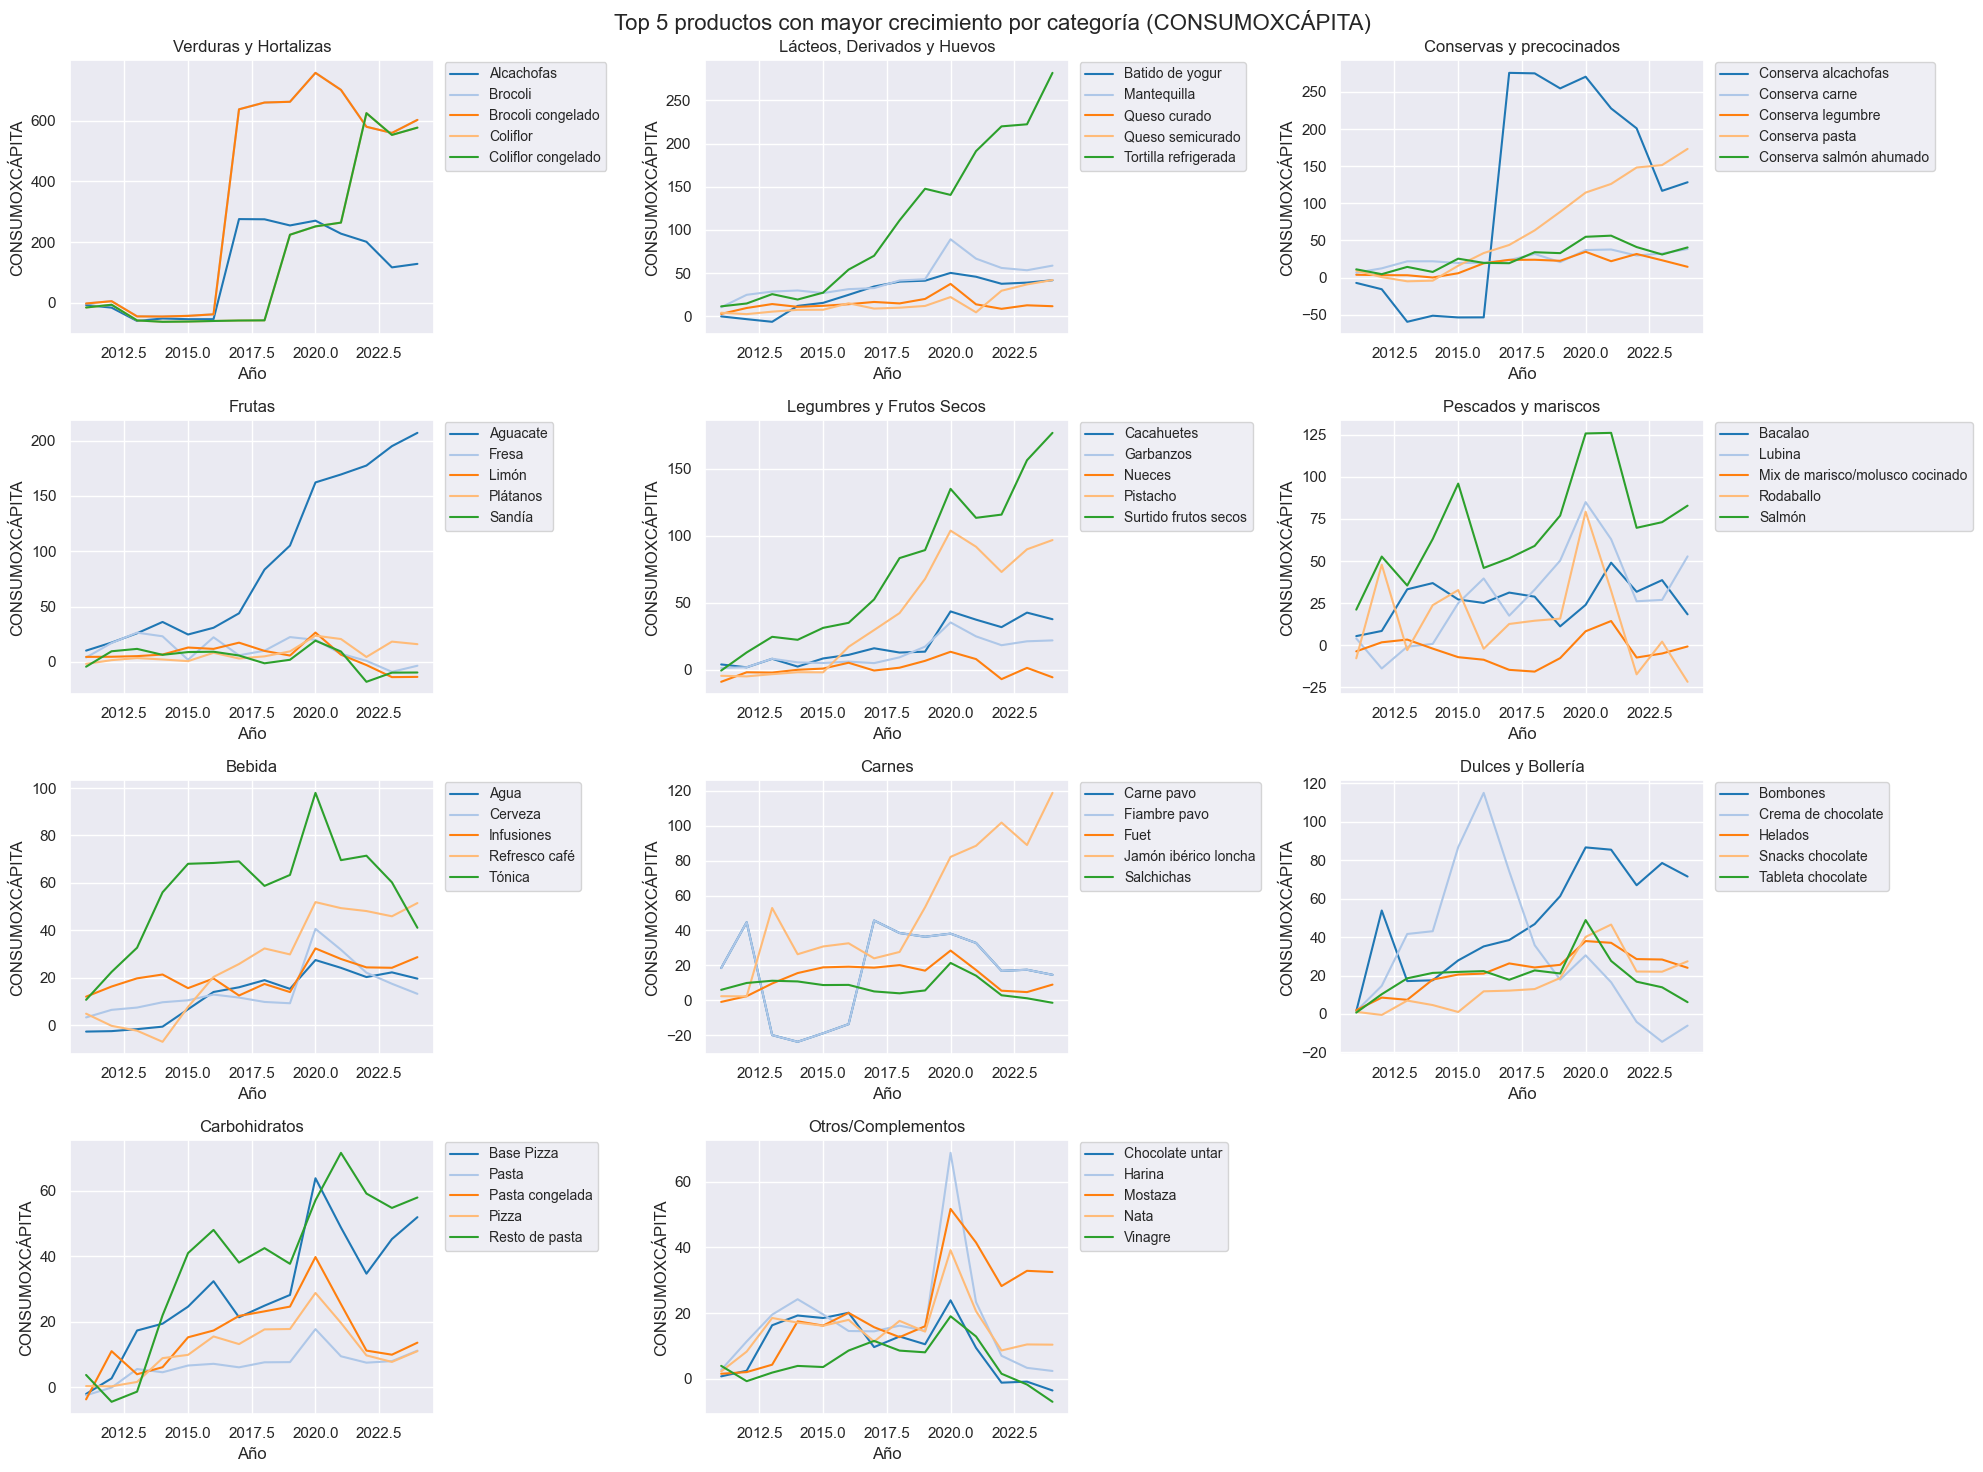

In [133]:
plot_top5_growth('PENETRACIÓN')
plot_top5_growth('PRECIO')
plot_top5_growth('GASTOXCÁPITA')
plot_top5_growth('CONSUMOXCÁPITA')

### 2.3 Decisión de clases a detectar en el futuro modelo

Se han decidido las clases sobre todo con los siguientes criterios:
- La penetración del producto ya que representa la cantidad porcentual de familias en España que han consumido este producto el año
- El ConsumoxCápita
- El crecimiento en comparación con 2010 para detectar productos que han tenido un crecimiento de penetración muy grande, lo que también indica que se están volviendo más populares.
- Criterio contextual: Solo escogeremos productos que típicamente son conservados en nevera, dado que el objetivo principal del máster es un modelo de detección de productos en la nevera. (En el futuro se podría hacer una ampliación para incluir también productos de despense)
- Criterio de transfer learning: Hay ciertos datasets para algunas clases de comida, en el caso de ser posible, se priorizarán productos de mayor consumo pero también los que tengan algún dataset de imágenes ya disponible.

In [130]:
spain_df['Categoría comida'].unique()

array(['Lácteos, Derivados y Huevos', 'Otros/Complementos', 'Carnes',
       'Pescados y mariscos', 'Conservas y precocinados',
       'Dulces y Bollería', 'Carbohidratos', 'Bebida',
       'Legumbres y Frutos Secos', 'Verduras y Hortalizas', 'Frutas'],
      dtype=object)

In [135]:
pivoted_spain_df.reset_index()

Categoría comida     Nombre Refinado CONSUMOXCÁPITA  \
dataset_year                                                      2010   
0                            Bebida                Agua      52.918334   
1                            Bebida  Bebida espirituosa            NaN   
2                            Bebida       Cacao soluble       1.246901   
3                            Bebida                Café       1.670012   
4                            Bebida             Cerveza      16.574741   
..                              ...                 ...            ...   
219           Verduras y Hortalizas           Pimientos       1.684914   
220           Verduras y Hortalizas              Puerro            NaN   
221           Verduras y Hortalizas             Rábanos            NaN   
222           Verduras y Hortalizas              Tomate       9.625941   
223           Verduras y Hortalizas          Zanahorias       3.410732   

                                                                     \
dataset_year       2011       2012       2013       2014       2015   
0             51.484357  51.586723  52.030002  52.583143  56.464146   
1                   NaN        NaN   0.000000   0.000000   0.726808   
2              1.231952   1.204952   1.275934   1.311156   1.357544   
3              1.709934   1.747373   1.803710   1.776159   1.730230   
4             17.114952  17.645661  17.803894  18.176185  18.313668   
..                  ...        ...        ...        ...        ...   
219            1.779081   1.798656   1.843435   1.827894   1.695653   
220                 NaN        NaN   0.000000   0.000000   0.000000   
221                 NaN        NaN        NaN        NaN        NaN   
222           10.214267   9.978648  10.144117   9.791749   9.693700   
223            3.449270   3.554690   3.639527   3.630203   3.416925   

                                    ...     PRECIO                        \
dataset_year       2016       2017  ...       2015       2016       2017   
0             60.323092  61.373219  ...   0.208597   0.210525   0.207830   
1              0.817508   0.741540  ...  10.489279  10.865181  10.657087   
2              1.314252   1.213538  ...   4.437272   4.389018   4.427611   
3              1.775427   1.698685  ...  14.021726  14.636843  14.694659   
4             18.713479  18.503891  ...   1.186006   1.200559   1.218046   
..                  ...        ...  ...        ...        ...        ...   
219            1.771071   1.682734  ...   2.645117   2.714528   2.716320   
220            0.000000   0.000000  ...        NaN        NaN        NaN   
221                 NaN        NaN  ...        NaN        NaN        NaN   
222            9.840225   9.040444  ...   1.394126   1.398889   1.470824   
223            3.495871   3.244516  ...   0.858414   0.846773   0.872601   

                                                                     \
dataset_year       2018       2019       2020       2021       2022   
0              0.208876   0.209220   0.203358   0.206228   0.211325   
1             10.647797  10.944379  10.979713  10.816056  11.533705   
2              4.499307   4.647547   4.806621   4.800363   5.300168   
3             15.240847  15.591888  15.517970  15.778594  17.374559   
4              1.263014   1.324167   1.378612   1.388471   1.479333   
..                  ...        ...        ...        ...        ...   
219            2.734920   2.802272   2.828712   2.855167   3.031503   
220                 NaN   2.695594   2.784883   2.946450   3.030775   
221                 NaN        NaN        NaN        NaN   2.377764   
222            1.485013   1.541549   1.590641   1.631821   1.875960   
223            0.906099   0.926570   0.956909   0.945099   1.034002   

                                    
dataset_year       2023       2024  
0              0.226906   0.232928  
1             12.313412  11.980091  
2              5.830092   6.144096  
3             18.285158  19.195224

In [137]:
penetration_change_vs_base.reset_index()

dataset_year       Categoría comida     Nombre Refinado  2010  2011  2012  \
0                            Bebida                Agua   0.0  0.56  0.70   
1                            Bebida  Bebida espirituosa   NaN   NaN   NaN   
2                            Bebida       Cacao soluble   0.0 -3.21 -3.76   
3                            Bebida                Café   0.0  1.70  3.41   
4                            Bebida             Cerveza   0.0  1.68  1.60   
..                              ...                 ...   ...   ...   ...   
219           Verduras y Hortalizas           Pimientos   0.0  1.01 -0.03   
220           Verduras y Hortalizas              Puerro   NaN   NaN   NaN   
221           Verduras y Hortalizas             Rábanos   NaN   NaN   NaN   
222           Verduras y Hortalizas              Tomate   0.0  0.90  1.29   
223           Verduras y Hortalizas          Zanahorias   0.0 -2.73 -2.15   

dataset_year   2013   2014   2015   2016   2017   2018   2019   2020    2021  \
0             -1.03  -0.41   2.02   4.55   8.38   9.59   5.49   4.22   85.16   
1               NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
2              6.98   8.21   6.49  -1.73  -1.55   0.30  -4.15  -1.27  209.09   
3              5.72   4.67   3.49   4.03   3.30   5.65   5.31  10.41   53.94   
4             -1.06  -1.97  -2.15  -1.54  -0.79  -1.44  -0.57   8.75   87.06   
..              ...    ...    ...    ...    ...    ...    ...    ...     ...   
219           24.47  21.92  18.50  19.90  18.75  20.87  22.80  30.64  138.78   
220             NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
221             NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
222           11.44   9.98   9.73   9.40   9.29   9.45   9.35  13.11   53.70   
223           23.74  22.76  19.29  17.48  14.26  16.05  18.84  27.48   99.19   

dataset_year    2022    2023    2024  
0              86.54   88.75   86.50  
1                NaN     NaN     NaN  
2             205.77  190.64  189.41  
3              53.90   53.30   53.12  
4              85.63   83.51   80.66  
..               ...     ...     ...  
219           139.55  140.41  140.55  
220              NaN     NaN     NaN  
221              NaN     NaN     NaN  
222            53.99   53.49   53.70  
223            99.95   98.95   98.91  

[224 rows x 17 columns]

In [177]:
grupos_a_considerar = [
    'Lácteos, Derivados y Huevos', 
    'Carnes',
    'Pescados y mariscos', 
    'Verduras y Hortalizas', 
    'Frutas'
]

## Paso 1. Obteniendo todos los dfs con los top 5 productos de cada categoría con mayor crecimiento de PENETRACIÓN y CONSUMOXCÁPITA
top5_crecimiento_dfs = {}

for metric in ['PENETRACIÓN', 'CONSUMOXCÁPITA']:

    penetration_base = pivoted_spain_df[metric][2010]
    penetration_change_vs_base = (pivoted_spain_df[metric].divide(penetration_base, axis=0) - 1) * 100
    penetration_change_vs_base = penetration_change_vs_base.round(2)

    penetration_change_vs_base = penetration_change_vs_base.reset_index()
    filtered_df = penetration_change_vs_base[penetration_change_vs_base['Categoría comida'].isin(grupos_a_considerar)]

    melted_df = pd.melt(
        filtered_df,
        id_vars=['Categoría comida', 'Nombre Refinado'],
        value_vars=filtered_df.columns[3:],  
        var_name='dataset_year',
        value_name=metric
    )

    top5_crecimiento = (
        melted_df
        .groupby(['Categoría comida', 'Nombre Refinado'])[metric]
        .mean()
        .reset_index()
        .sort_values(by=metric, ascending=False)
        .groupby('Categoría comida')
        .head(5)
    )

    top5_crecimiento_dfs[metric] = top5_crecimiento

top5_crecimiento_penetración = top5_crecimiento_dfs['PENETRACIÓN']
top5_crecimiento_penetración['rank'] = top5_crecimiento_penetración.groupby('Categoría comida')['PENETRACIÓN'].rank(ascending=False, method='first')
top5_crecimiento_penetración['Top 5 Penetración crecimiento'] = top5_crecimiento_penetración['Nombre Refinado']

top5_crecimiento_consumoxcapita = top5_crecimiento_dfs['CONSUMOXCÁPITA']
top5_crecimiento_consumoxcapita['rank'] = top5_crecimiento_consumoxcapita.groupby('Categoría comida')['CONSUMOXCÁPITA'].rank(ascending=False, method='first')
top5_crecimiento_consumoxcapita['Top 5 ConsumoXCápita crecimiento'] = top5_crecimiento_consumoxcapita['Nombre Refinado']


## Paso 2. Obteniendo todos los dfs con los top 10 productos de cada categoría con mayor PENETRACIÓN y CONSUMOXCÁPITA

top10_penetracion = spain_df.groupby(['Categoría comida', 'Nombre Refinado'])["PENETRACIÓN"].mean().reset_index().sort_values(by="PENETRACIÓN", ascending=False).groupby('Categoría comida').head(10).sort_values(by=['Categoría comida', "PENETRACIÓN"], ascending=False)
top10_penetracion['rank'] = top10_penetracion.groupby('Categoría comida')['PENETRACIÓN'].rank(ascending=False, method='first')
top10_penetracion['Top 10 Penetración'] = top10_penetracion['Nombre Refinado']

top10_consumoxcapita = spain_df.groupby(['Categoría comida', 'Nombre Refinado'])["CONSUMOXCÁPITA"].mean().reset_index().sort_values(by="CONSUMOXCÁPITA", ascending=False).groupby('Categoría comida').head(10).sort_values(by=['Categoría comida', "CONSUMOXCÁPITA"], ascending=False)
top10_consumoxcapita['rank'] = top10_consumoxcapita.groupby('Categoría comida')['CONSUMOXCÁPITA'].rank(ascending=False, method='first')
top10_consumoxcapita['Top 10 ConsumoXCápita'] = top10_consumoxcapita['Nombre Refinado']

## Paso 3. Hago merge de todos los dfs para tener una tabla resumen final
merge_1 = pd.merge(top5_crecimiento_penetración, top5_crecimiento_consumoxcapita, on=['Categoría comida','rank'], how='inner')
merge_2 = pd.merge(top10_penetracion, top10_consumoxcapita, on=['Categoría comida','rank'], how='inner')
merge_top_productos_final = pd.merge(merge_2, merge_1, on=['Categoría comida','rank'], how='left')

## Paso 4. Selecciono solamente las columnas necesarias

top_productos_final_tratado = merge_top_productos_final[['Categoría comida', 'Top 10 Penetración', 'Top 10 ConsumoXCápita', 'Top 5 Penetración crecimiento', 'Top 5 ConsumoXCápita crecimiento']]

In [183]:
#Productos de verdura y hortalizas
top_productos_final_tratado[top_productos_final_tratado['Categoría comida'] == "Verduras y Hortalizas"]

Categoría comida Top 10 Penetración Top 10 ConsumoXCápita  \
0  Verduras y Hortalizas             Tomate         Patata fresca   
1  Verduras y Hortalizas            Cebolla                Tomate   
2  Verduras y Hortalizas      Patata fresca               Cebolla   
3  Verduras y Hortalizas    Lechuga/Endivia       Lechuga/Endivia   
4  Verduras y Hortalizas         Zanahorias           Calabacines   
5  Verduras y Hortalizas           Calabaza            Zanahorias   
6  Verduras y Hortalizas        Calabacines                Pepino   
7  Verduras y Hortalizas                Ajo             Pimientos   
8  Verduras y Hortalizas  Champiñones/Setas    Pimiento congelado   
9  Verduras y Hortalizas             Pepino            Berenjenas   

  Top 5 Penetración crecimiento Top 5 ConsumoXCápita crecimiento  
0             Brocoli congelado                Brocoli congelado  
1                       Brocoli                          Brocoli  
2                      Coliflor                         Coliflor  
3            Coliflor congelado               Coliflor congelado  
4                    Alcachofas                       Alcachofas  
5                           NaN                              NaN  
6                           NaN                              NaN  
7                           NaN                              NaN  
8                           NaN                              NaN  
9                           NaN                              NaN

De verduras escogeremos 10.
Hay overlap de casi todos los productos en top 10 penetración y top 10 consumoxcápita, menos:
- Ajo
- Calabaza
- Champiñones

De aquí tomamos 8 clases: [Tomate, Cebolla, Patata fresca, Lechuga/Endivia, Zanahorias, Calabacines, Pepino, Champiñones] (a pesar de que Champiñones no ha tenido solapamiento, se dispone de un dataset de imágenes de champiñones)


Mientras tanto vemos que Top 5 crecimiento de penetración y consumoxcápita coinciden al 100%. Cogemos Coliflor y Brocoli ya que son las dos clases con más crecimiento (ignoramos los productos congelados.)

In [184]:
grupos_a_considerar

['Lácteos, Derivados y Huevos',
 'Carnes',
 'Pescados y mariscos',
 'Verduras y Hortalizas',
 'Frutas']

In [185]:
#Productos de Lácteos, Derivados y Huevos
top_productos_final_tratado[top_productos_final_tratado['Categoría comida'] == 'Lácteos, Derivados y Huevos']

Categoría comida Top 10 Penetración Top 10 ConsumoXCápita  \
30  Lácteos, Derivados y Huevos     Leche envasada                Huevos   
31  Lácteos, Derivados y Huevos             Huevos        Leche envasada   
32  Lácteos, Derivados y Huevos              Yogur                 Yogur   
33  Lácteos, Derivados y Huevos   Queso leche vaca       Batido de leche   
34  Lácteos, Derivados y Huevos       Queso fresco          Queso fresco   
35  Lácteos, Derivados y Huevos  Queso leche cabra      Queso semicurado   
36  Lácteos, Derivados y Huevos  Queso leche oveja       Batido de yogur   
37  Lácteos, Derivados y Huevos   Queso semicurado         Queso fundido   
38  Lácteos, Derivados y Huevos      Queso fundido      Queso leche vaca   
39  Lácteos, Derivados y Huevos       Queso tierno     Queso leche cabra   

   Top 5 Penetración crecimiento Top 5 ConsumoXCápita crecimiento  
30          Tortilla refrigerada             Tortilla refrigerada  
31                 Queso de bola                      Mantequilla  
32                  Queso curado                  Batido de yogur  
33                    Queso azul                 Queso semicurado  
34                   Mantequilla                     Queso curado  
35                           NaN                              NaN  
36                           NaN                              NaN  
37                           NaN                              NaN  
38                           NaN                              NaN  
39                           NaN                              NaN

De Lácteos, Derivados y Huevos escogeremos 6.
Hay overlap de casi todos los productos en top 10 penetración y top 10 consumoxcápita, menos:
- Queso leche oveja
- Queso tierno

De aquí tomamos 5 clases: [Leche envasada, Huevos, Yogur, Queso Lonchas, Queso fresco] (se ha simplificado los diferentes tipos de queso en lonchas)

Mientras tanto vemos que Top 5 crecimiento de penetración y consumoxcápita coinciden tortilla refrigerada, queso curado y mantequilla. Queso curado se consideraría como queso loncha. Se escoge mantequilla como clase extra a predecir dado que está disponible en un dataset público y adicionalmente es un ingrediente muy común en muchas recetas.

In [186]:
#Productos de Carnes
top_productos_final_tratado[top_productos_final_tratado['Categoría comida'] == 'Carnes']

Categoría comida   Top 10 Penetración Top 10 ConsumoXCápita  \
80           Carnes          Carne pollo           Carne pollo   
81           Carnes          Carne cerdo           Carne cerdo   
82           Carnes         Carne vacuno          Carne vacuno   
83           Carnes  Jamón curado loncha   Carne ovino/caprino   
84           Carnes         Jamón Cocido            Salchichas   
85           Carnes              Chorizo       Carne congelada   
86           Carnes           Salchichas          Jamón Cocido   
87           Carnes           Carne pavo            Carne pavo   
88           Carnes         Fiambre pavo          Fiambre pavo   
89           Carnes                 Fuet   Jamón curado loncha   

   Top 5 Penetración crecimiento Top 5 ConsumoXCápita crecimiento  
80          Jamón ibérico entero             Jamón ibérico loncha  
81          Jamón ibérico loncha                       Carne pavo  
82                  Fiambre pavo                     Fiambre pavo  
83                    Carne pavo                             Fuet  
84               Huesos de jamón                       Salchichas  
85                           NaN                              NaN  
86                           NaN                              NaN  
87                           NaN                              NaN  
88                           NaN                              NaN  
89                           NaN                              NaN

De esta categoría escogeremos las siguientes 5 clases:
["Carne pollo", "Carne cerdo", "Carne vacuno", "Salchichas", "Carne pavo"]

Esto es debido a que estas 5 categorías aparecen en múltiples columnas

### 2.4 Datos socioeconómicos sobre las clases a utilizar

In [ ]:
merge_top_productos_final[]

Categoría comida  Nombre Refinado_x_x  PENETRACIÓN_x  rank  \
0    Verduras y Hortalizas               Tomate      74.082500   1.0   
1    Verduras y Hortalizas              Cebolla      72.150239   2.0   
2    Verduras y Hortalizas        Patata fresca      71.232500   3.0   
3    Verduras y Hortalizas      Lechuga/Endivia      68.449233   4.0   
4    Verduras y Hortalizas           Zanahorias      63.379139   5.0   
..                     ...                  ...            ...   ...   
103                 Bebida           Infusiones      36.552278   6.0   
104                 Bebida        Cacao soluble      30.308289   7.0   
105                 Bebida  Refresco de naranja      27.977039   8.0   
106                 Bebida   Refresco isotónico      23.713783   9.0   
107                 Bebida    Refresco de limón      22.277489  10.0   

      Top 10 Penetración Nombre Refinado_y_x  CONSUMOXCÁPITA_x  \
0                 Tomate       Patata fresca         21.298525   
1                Cebolla              Tomate          9.379708   
2          Patata fresca             Cebolla          7.140295   
3        Lechuga/Endivia     Lechuga/Endivia          4.137127   
4             Zanahorias         Calabacines          3.805713   
..                   ...                 ...               ...   
103           Infusiones             Gaseosa          3.477437   
104        Cacao soluble   Refresco de limón          2.908341   
105  Refresco de naranja  Refresco isotónico          2.782086   
106   Refresco isotónico        Zumo + Leche          2.764874   
107    Refresco de limón       Refresco café          1.940230   

    Top 10 ConsumoXCápita Nombre Refinado_x_y  PENETRACIÓN_y  \
0           Patata fresca   Brocoli congelado     889.384286   
1                  Tomate             Brocoli     889.384286   
2                 Cebolla            Coliflor     572.245000   
3         Lechuga/Endivia  Coliflor congelado     572.245000   
4             Calabacines          Alcachofas     138.320714   
..                    ...                 ...            ...   
103               Gaseosa                 NaN            NaN   
104     Refresco de limón                 NaN            NaN   
105    Refresco isotónico                 NaN            NaN   
106          Zumo + Leche                 NaN            NaN   
107         Refresco café                 NaN            NaN   

      Top 5 Penetración Nombre Refinado_y_y  CONSUMOXCÁPITA_y  \
0     Brocoli congelado   Brocoli congelado        356.542143   
1               Brocoli             Brocoli        356.542143   
2              Coliflor            Coliflor        151.157857   
3    Coliflor congelado  Coliflor congelado        151.157857   
4            Alcachofas          Alcachofas        107.802857   
..                  ...                 ...               ...   
103                 NaN                 NaN               NaN   
104                 NaN                 NaN               NaN   
105                 NaN                 NaN               NaN   
106                 NaN                 NaN               NaN   
107                 NaN                 NaN               NaN   

    Top 5 ConsumoXCápita  
0      Brocoli congelado  
1                Brocoli  
2               Coliflor  
3     Coliflor congelado  
4             Alcachofas  
..                   ...  
103                  NaN  
104                  NaN  
105                  NaN  
106                  NaN  
107                  NaN  

[108 rows x 14 columns]